This is the python file to analyze trajectories from MD

# import packages

In [17]:
import scipy as sc
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from ase import io
from ase.units import *
import ase
import itertools

In [5]:
#from ase import io
#from ase.units import *
#snap1 = ase.io.read("../../../Study/1Cl/nvt/pimd/data.pos_0.xyz",':')
#ase.io.write('slab.png', snap1[0]) #rotation='10z,-80x')
#snap1[0].get_cell()
#snap1[0].set_cell([12.4,12.4,12.4],scale_atoms=True)
#snap1[0].set_pbc(111)
#snap1[0].get_distances(0,2,vector=True)
#snap1[0].get_positions()

#test.info
#test.get_masses()
#test.get_atomic_numbers()
#np.zeros([3,3],np.int_)
#test.wrap()
#test.get_scaled_positions()
#test.wrap(test.get_scaled_positions()[0])
#ase.io.write('test.xyz',test)

In [6]:
#write qe cl output to xyz
"""
with open("../../../Study/1Cl/nvt/bomd/cl.pos",'r') as ifs:
    with open("../../../Study/1Cl/nvt/bomd/cl.xyz",'w') as ofs:
        label = ["Cl"] + ["O"]*63 + ["H"]*126
        count = 0
        for line in ifs.readlines():
            if len(line.split()) == 2:
                ofs.write("190\n")
                ofs.write("#" + line)
                count = 0
            else:
                ofs.write(label[count]+" ")
                ofs.write(line)
                count += 1
"""   

'\nwith open("../../../Study/1Cl/nvt/bomd/cl.pos",\'r\') as ifs:\n    with open("../../../Study/1Cl/nvt/bomd/cl.xyz",\'w\') as ofs:\n        label = ["Cl"] + ["O"]*63 + ["H"]*126\n        count = 0\n        for line in ifs.readlines():\n            if len(line.split()) == 2:\n                ofs.write("190\n")\n                ofs.write("#" + line)\n                count = 0\n            else:\n                ofs.write(label[count]+" ")\n                ofs.write(line)\n                count += 1\n'

# Load files

In [7]:
#read in quantum snapshots
snap = []
for i in range(0,8):
    print("Reading", i)
    snap.append(ase.io.read("../../../Study/1Cl/nvt/pimd/data.pos_"+str(i)+".xyz",'10000:33000:5'))

Reading 0
Reading 1
Reading 2
Reading 3
Reading 4
Reading 5
Reading 6
Reading 7


In [8]:
#read in classical snapshots
snap_c = ase.io.read("../../../Study/1Cl/nvt/bomd/cl.xyz",'10000:81000:5')

In [9]:
#set pbc and cell, change the unit of positions to angstrom
for beads in snap:
    for sn in beads:
        sn.set_pbc(111)
        sn.set_cell([23.47*Bohr,23.47*Bohr,23.47*Bohr])
        sn.set_positions(sn.get_positions()*Bohr)

In [10]:
for sn in snap_c:
        sn.set_pbc(111)
        sn.set_cell([23.47*Bohr,23.47*Bohr,23.47*Bohr])
        sn.set_positions(sn.get_positions()*Bohr)

In [11]:
test = snap_c[0].copy()
test.wrap(test.get_scaled_positions()[0])
test.write('test.xyz')

# Define basic functions

In [12]:
# water
def water(indexO):
    """Returns the value for H in the water, 
    Input should be from 1 to 63"""
    return (indexO*2+62,indexO*2+63)


In [13]:
#define Distribution function
class DF:
    """class of Distribution function
        init with steps and limits tuple
        read(ndarray)
        get_x,get_y for result
    """
    def __init__(self,steps = 100,limits=(0,1)):
        self.steps = steps
        self.limits = limits
        self.df,self.edges = np.histogram([],steps,limits)
    def read(self,nparray):
        self.df += np.histogram(nparray,self.steps,self.limits)[0]
    def get_x(self):
        return 0.5 * (self.edges[:-1]+self.edges[1:])
    def get_y(self):
        vol = self.edges[1:] - self.edges[:-1] 
        return self.df/self.df.sum()/vol
    def plot(self,in_label=""):
        plt.plot(self.get_x(),self.get_y(),label=in_label)

# G_ClO

In [829]:
#calculate rdf_classic
rdf,edges = np.histogram([],500,(0,6))
boxvolume = 0.
numframes = 0.
pointscount = 0.

for sn in snap_c:
    O = np.where(sn.get_atomic_numbers()==8)[0]
    rdf_data = sn.get_distances(0,O,mic=True)
    boxvolume += sn.get_volume()
    numframes += 1
    pointscount += len(rdf_data)
    rdf+=np.histogram(rdf_data,500,(0,6))[0]

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
vol = (4. / 3.) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
# normalization to the average density n/boxvolume in the simulation
G_ClO_c = rdf*boxvolume/numframes/pointscount/vol
G_ClO_x = radii

In [830]:
#calculate rdf_quantum
rdf,edges = np.histogram([],500,(0,6))
boxvolume = 0.
numframes = 0.
pointscount = 0.

for beads in snap:
    for sn in beads:
        O = np.where(sn.get_atomic_numbers()==8)[0]
        rdf_data = sn.get_distances(0,O,mic=True)
        boxvolume += sn.get_volume()
        numframes += 1
        pointscount += len(rdf_data)
        rdf+=np.histogram(rdf_data,500,(0,6))[0]

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
vol = (4. / 3.) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
# normalization to the average density n/boxvolume in the simulation
G_ClO_q = rdf*boxvolume/numframes/pointscount/vol

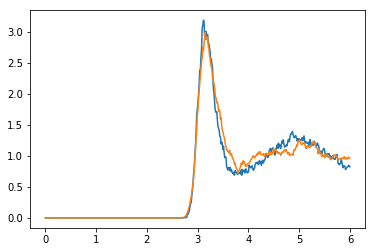

In [515]:
plt.plot(radii,real_rdf)
plt.plot(radii,real_rdf_q)

# OClO angle

In [1414]:
rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    rdf += np.histogram(angles,500,(0,180))[0]
    pointscount += angles.size

rdf.astype(np.float64)
G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
G_ClO_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        rdf += np.histogram(angles,500,(0,180))[0]
        pointscount += angles.size

rdf.astype(np.float64)
G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
G_ClO_q = rdf/pointscount/vol

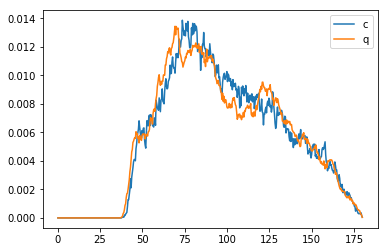

In [1415]:
plt.plot(G_OClO_x,G_ClO_c,label="c")
plt.plot(G_OClO_x,G_ClO_q,label="q")
plt.legend()

In [18]:
# not only in first shell but second
G_OClO_all_c = DF(500,(0,180))
G_OClO_all_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.4)[0]+1
    if(Os.size>1):
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        G_OClO_all_c.read(angles)

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.4)[0]+1
        if(Os.size>1):
            angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
            G_OClO_all_q.read(angles)


In [20]:
# not only in first shell but second
G_OClO_all_c = DF(500,(0,180))
G_OClO_all_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where((tmp>3.4)&(tmp<3.8))[0]+1
    if(Os.size>1):
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        G_OClO_all_c.read(angles)

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where((tmp>3.4)&(tmp<3.8))[0]+1
        if(Os.size>1):
            angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
            G_OClO_all_q.read(angles)


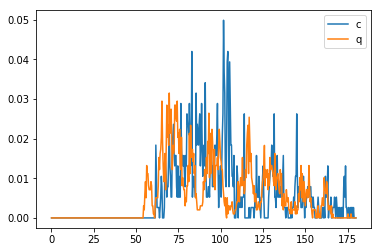

In [1527]:
#<3
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

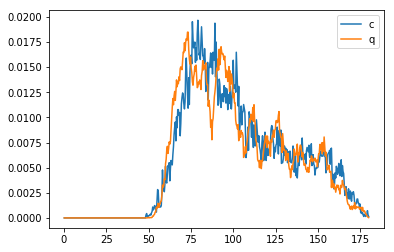

In [1529]:
#<3.2
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

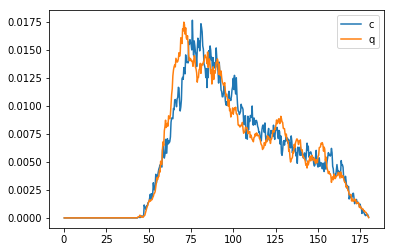

In [19]:
#<3.4
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

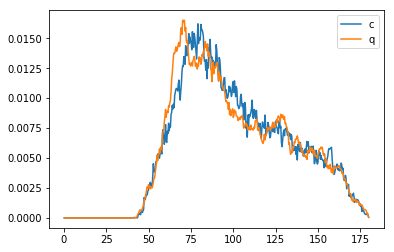

In [1531]:
#<3.5
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

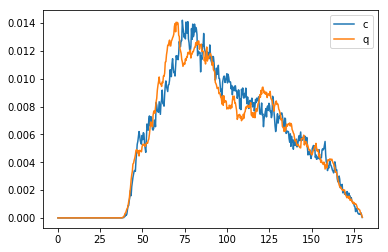

In [1533]:
#<3.8
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

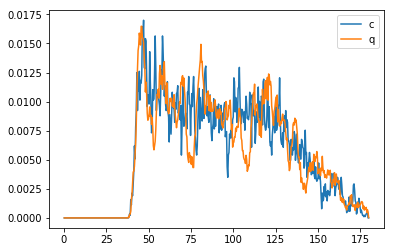

In [21]:
#3.4~3.8
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

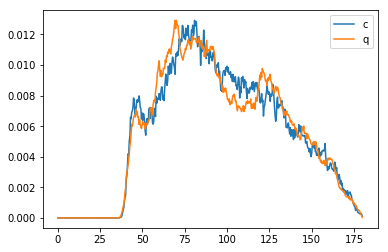

In [1535]:
#<4
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

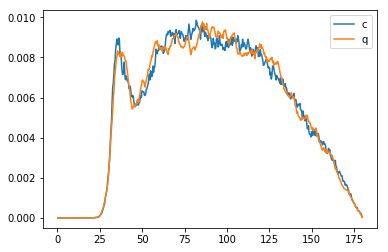

In [1525]:
#<5
G_OClO_all_c.plot("c")
G_OClO_all_q.plot("q")
plt.legend()

In [1424]:
G_OClO_c = DF(500,(0,180))
G_HClH_c = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    G_OClO_c.read(angles)
    '''
    H1s,H2s = water(Os)
    Hs = np.concatenate(H1s,H2s)
    anglesH = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Hs,2))),1,0,axis=1),mic=True)
    G_HClH_c.read(anglesH)
    '''
    Hs = range(64,190)
    tmp = sn.get_distances(0,Hs,mic=True)
    Hs = np.where(tmp<2.87)[0]+64
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Hs,2))),1,0,axis=1),mic=True)
    G_HClH_c.read(angles)

G_OClO_q = DF(500,(0,180))
G_HClH_q = DF(500,(0,180))

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.83)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        G_OClO_q.read(angles)
        Hs = range(64,190)
        tmp = sn.get_distances(0,Hs,mic=True)
        Hs = np.where(tmp<2.87)[0]+64
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Hs,2))),1,0,axis=1),mic=True)
        G_HClH_q.read(angles)


In [1436]:
D_HClH_e = np.loadtxt("/Users/jianhangxu/Library/Mobile Documents/com~apple~CloudDocs/study/work/2WCl/1npt/1structure/2G_XX/expr/P_H-Cl-H.txt")

In [1452]:
D_HClH_e_y = D_HClH_e[:,1]*np.sin(D_HClH_e[:,0]*np.pi/180)
D_HClH_e_dx = np.concatenate((D_HClH_e[1:,0]-D_HClH_e[:-1,0],[1.1]))
D_HClH_e_y_normalized = D_HClH_e_y/(D_HClH_e_dx*D_HClH_e_y).sum()

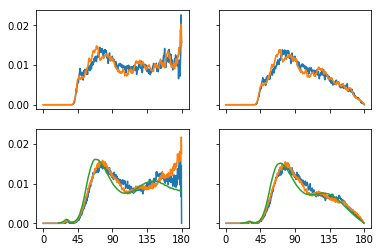

In [1453]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
plt.setp(ax,xticks=[0, 45, 90, 135, 180])
ax[0,0].plot(G_OClO_c.get_x(),G_OClO_c.get_y()/np.sin(G_OClO_c.get_x()*np.pi/180),label="c")
ax[0,0].plot(G_OClO_q.get_x(),G_OClO_q.get_y()/np.sin(G_OClO_q.get_x()*np.pi/180),label="q")
ax[0,1].plot(G_OClO_c.get_x(),G_OClO_c.get_y(),label="c")
ax[0,1].plot(G_OClO_q.get_x(),G_OClO_q.get_y(),label="q")
ax[1,0].plot(G_HClH_c.get_x(),G_HClH_c.get_y()/np.sin(G_HClH_c.get_x()*np.pi/180),label="c")
ax[1,0].plot(G_HClH_q.get_x(),G_HClH_q.get_y()/np.sin(G_HClH_q.get_x()*np.pi/180),label="q")
ax[1,0].plot(D_HClH_e[:,0],D_HClH_e_y_normalized/np.sin(D_HClH_e[:,0]*np.pi/180),label="e")
ax[1,1].plot(G_HClH_c.get_x(),G_HClH_c.get_y(),label="c")
ax[1,1].plot(G_HClH_q.get_x(),G_HClH_q.get_y(),label="q")
ax[1,1].plot(D_HClH_e[:,0],D_HClH_e_y_normalized,label="e")
#fig.legend()

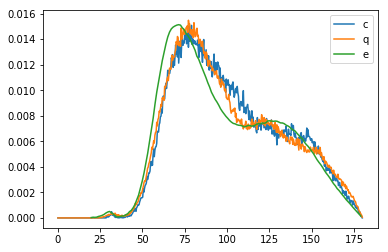

In [1454]:
plt.plot(G_HClH_c.get_x(),G_HClH_c.get_y(),label="c")
plt.plot(G_HClH_q.get_x(),G_HClH_q.get_y(),label="q")
plt.plot(D_HClH_e[:,0],D_HClH_e_y_normalized,label="e")
plt.legend()

## seperate by nonbonded O

In [1228]:
#OClO angles by nonbonded N O
HB_HOCl_cutoff = 30
rdf,edges = np.histogram([],500,(0,180))
rdfs = []
for i in range(10):
    rdfs.append(rdf.copy())

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1>HB_HOCl_cutoff)]
    d2 = Os[np.where(angles2>HB_HOCl_cutoff)]
    nO = np.intersect1d(d1,d2).size
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    rdfs[nO] += np.histogram(angles,500,(0,180))[0]

G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
G_ClO_nO_c = rdfs

rdfs = []
for i in range(10):
    rdfs.append(rdf.copy())

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        length = Os.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1>HB_HOCl_cutoff)]
        d2 = Os[np.where(angles2>HB_HOCl_cutoff)]
        nO = np.intersect1d(d1,d2).size
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        rdfs[nO] += np.histogram(angles,500,(0,180))[0]

G_ClO_nO_q = rdfs


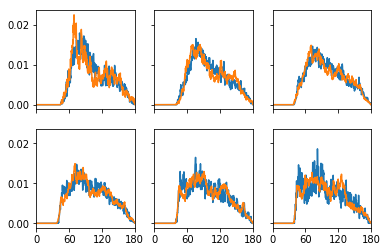

In [1381]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
plt.setp(ax, xticks=[0, 60, 120,180])
for i in range(2):
    for j in range(3):
        k=i*3+j
        ax[i][j].plot(G_OClO_x,G_ClO_nO_c[k]/G_ClO_nO_c[k].sum()/0.36,label="c"+str(k))
        ax[i][j].plot(G_OClO_x,G_ClO_nO_q[k]/G_ClO_nO_q[k].sum()/0.36,label="q"+str(k))
        ax[i][j].set_xlim((0,180))
        #ax[i][j].legend()

## seperate by Bonded water

## seperate by CN

In [893]:
#find snapshot with 4 115-125 angles
rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.
pointscounts = []
rdfs = []
for i in range(15):
    rdfs.append(rdf.copy())
    pointscounts.append(0)

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    nO = Os.size
    if(nO<15):
        rdfs[nO] += np.histogram(angles,500,(0,180))[0]
        pointscounts[nO]  += angles.size

rdf.astype(np.float64)
G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
G_ClO_cn_c = [] 
for i in range(15):
    G_ClO_cn_c.append(rdfs[i]/pointscounts[i]/vol)

pointscounts = []
rdfs = []
for i in range(15):
    rdfs.append(rdf.copy())
    pointscounts.append(0)

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        nO = Os.size
        if(nO<15):
            rdfs[nO] += np.histogram(angles,500,(0,180))[0]
            pointscounts[nO]  += angles.size

G_ClO_cn_q = [] 
for i in range(15):
    G_ClO_cn_q.append(rdfs[i]/pointscounts[i]/vol)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


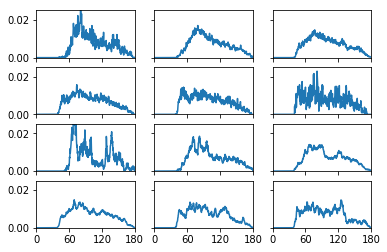

In [901]:
fig, ax = plt.subplots(4,3,sharex=True,sharey=True)
plt.setp(ax, xticks=[0, 60, 120,180])
for i in {0,1}:
    for j in {0,1,2}:
        ax[i,j].plot(G_OClO_x,G_ClO_cn_c[5+3*i+j],label=str(5+3*i+j)+'-c')
        #ax[i,j].legend()
        ax[i,j].set_ylim(0,0.025)
        ax[i,j].set_xlim(0,180)
for i in {2,3}:
    for j in {0,1,2}:
        ax[i,j].plot(G_OClO_x,G_ClO_cn_q[-1+3*i+j],label=str(-1+3*i+j)+'-q')
        #ax[i,j].legend()
        ax[i,j].set_ylim(0,0.025)
        ax[i,j].set_xlim(0,180)
#plt.setp(ax, xticks=[0.1, 0.5, 0.9], xticklabels=['a', 'b', 'c'],yticks=[1, 2, 3])

# Proton transfer coordinate

## O - O

In [1108]:
rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for sn in snap_c:
    Os = np.arange(1,64)
    tmp_dist = sn.get_all_distances(mic=True)
    O1_t,O2_t = np.where(tmp_dist[1:64,1:64] < 3.35)
    O1s = O1_t[O1_t!=O2_t]+1
    O2s = O2_t[O1_t!=O2_t]+1
    H1s = O1s*2 + 62
    H2s = O1s*2 + 63
    #dO1H1 - dO2H1
    rdf += np.histogram(tmp_dist[O1s,H1s]-tmp_dist[O2s,H1s],500,(-4,0))[0]
    rdf += np.histogram(tmp_dist[O1s,H2s]-tmp_dist[O2s,H2s],500,(-4,0))[0]
    pointscount += O1s.size*2
    
rdf.astype(np.float64)
PTC_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
PTC_OO_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = np.arange(1,64)
        tmp_dist = sn.get_all_distances(mic=True)
        O1_t,O2_t = np.where(tmp_dist[1:64,1:64] < 3.35)
        O1s = O1_t[O1_t!=O2_t]+1
        O2s = O2_t[O1_t!=O2_t]+1
        H1s = O1s*2 + 62
        H2s = O1s*2 + 63
        #dO1H1 - dO2H1
        rdf += np.histogram(tmp_dist[O1s,H1s]-tmp_dist[O2s,H1s],500,(-4,0))[0]
        rdf += np.histogram(tmp_dist[O1s,H2s]-tmp_dist[O2s,H2s],500,(-4,0))[0]
        pointscount += O1s.size*2
    
rdf.astype(np.float64)
PTC_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
PTC_OO_q = rdf/pointscount/vol

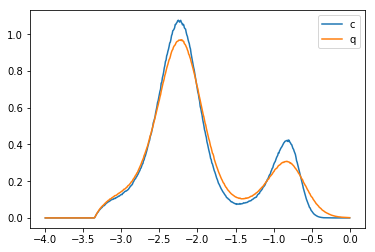

In [1109]:
plt.plot(PTC_x,PTC_OO_c,label="c")
plt.plot(PTC_x,PTC_OO_q,label="q")
plt.legend()

In [1110]:
rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for sn in snap_c:
    Os = np.arange(1,64)
    tmp_dist = sn.get_all_distances(mic=True)
    O1_t,O2_t = np.where(tmp_dist[1:64,1:64] < 3.35)
    O1s = O1_t[O1_t!=O2_t]+1
    O2s = O2_t[O1_t!=O2_t]+1
    tmp_pos = tmp_dist[0,O1s]<3.83
    O1s = O1s[tmp_pos]
    O2s = O2s[tmp_pos]
    H1s = O1s*2 + 62
    H2s = O1s*2 + 63
    #dO1H1 - dO2H1
    rdf += np.histogram(tmp_dist[O1s,H1s]-tmp_dist[O2s,H1s],500,(-4,0))[0]
    rdf += np.histogram(tmp_dist[O1s,H2s]-tmp_dist[O2s,H2s],500,(-4,0))[0]
    pointscount += O1s.size*2
    
rdf.astype(np.float64)
PTC_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
PTC_OO_first_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = np.arange(1,64)
        tmp_dist = sn.get_all_distances(mic=True)
        O1_t,O2_t = np.where(tmp_dist[1:64,1:64] < 3.35)
        O1s = O1_t[O1_t!=O2_t]+1
        O2s = O2_t[O1_t!=O2_t]+1
        tmp_pos = tmp_dist[0,O1s]<3.9
        O1s = O1s[tmp_pos]
        O2s = O2s[tmp_pos]
        H1s = O1s*2 + 62
        H2s = O1s*2 + 63
        #dO1H1 - dO2H1
        rdf += np.histogram(tmp_dist[O1s,H1s]-tmp_dist[O2s,H1s],500,(-4,0))[0]
        rdf += np.histogram(tmp_dist[O1s,H2s]-tmp_dist[O2s,H2s],500,(-4,0))[0]
        pointscount += O1s.size*2
    
rdf.astype(np.float64)
PTC_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
PTC_OO_first_q = rdf/pointscount/vol

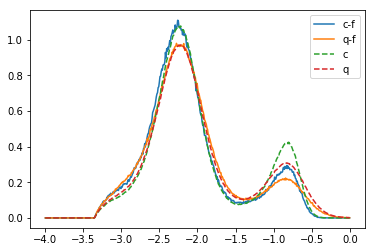

In [1121]:
plt.plot(PTC_x,PTC_OO_first_c,label="c-f")
plt.plot(PTC_x,PTC_OO_first_q,label="q-f")
plt.plot(PTC_x,PTC_OO_c,linestyle='--',label="c")
plt.plot(PTC_x,PTC_OO_q,linestyle='--',label="q")
plt.legend()

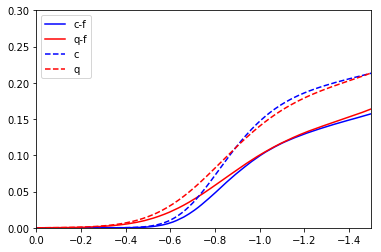

In [1316]:
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_first_c[::-1]*0.008),color='blue',label="c-f")
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_first_q[::-1]*0.008),color='red',label="q-f")
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_c[::-1]*0.008),color='blue',linestyle='--',label="c")
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_q[::-1]*0.008),color='red',linestyle='--',label="q")
plt.xlim(0,-1.5)
plt.ylim(0,0.3)
plt.legend()


## Cl - O

In [939]:
waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)

rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp_dist = sn.get_all_distances(mic=True)
    dOCl_all = tmp_dist[0][1:63]
    #waters
    Os = np.where(dOCl_all<3.83)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    #dOH1 - dClH1
    rdf += np.histogram(tmp_dist[Os,H1s]-tmp_dist[0][H1s],500,(-4,0))[0]
    rdf += np.histogram(tmp_dist[Os,H2s]-tmp_dist[0][H2s],500,(-4,0))[0]
    pointscount += Os.size*2

rdf.astype(np.float64)
PTC_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
PTC_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(-4,0))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp_dist = sn.get_all_distances(mic=True)
        dOCl_all = tmp_dist[0][1:63]
        #waters
        Os = np.where(dOCl_all<3.9)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        #dOH1 - dClH1
        rdf += np.histogram(tmp_dist[Os,H1s]-tmp_dist[0][H1s],500,(-4,0))[0]
        rdf += np.histogram(tmp_dist[Os,H2s]-tmp_dist[0][H2s],500,(-4,0))[0]
        pointscount += Os.size*2
PTC_q = rdf/pointscount/vol

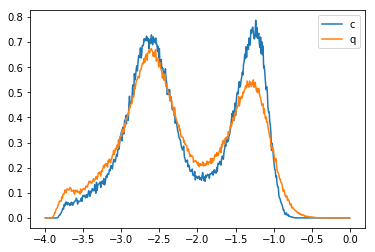

In [940]:
plt.plot(PTC_x,PTC_c,label="c")
plt.plot(PTC_x,PTC_q,label="q")
plt.legend()

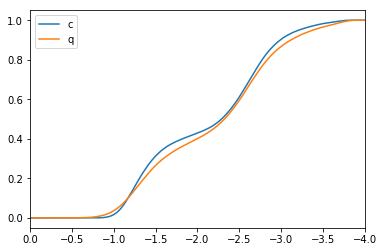

In [1063]:
plt.plot(PTC_x[::-1],np.cumsum(PTC_c[::-1]*0.008),label="c")
plt.plot(PTC_x[::-1],np.cumsum(PTC_q[::-1]*0.008),label="q")
plt.xlim(0,-4)
plt.legend()

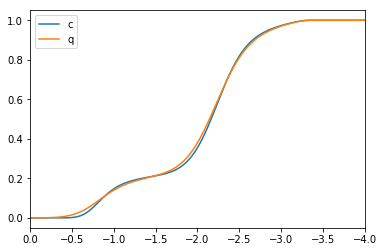

In [1123]:
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_c[::-1]*0.008),label="c")
plt.plot(PTC_x[::-1],np.cumsum(PTC_OO_q[::-1]*0.008),label="q")
plt.xlim(0,-4)
plt.legend()

# H-Bond

## water - water H-bond

In [507]:
#calculate bonding information 
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
HB_OO_cutoff = 3.5
HB_HOO_cutoff = 30
waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes = 0.
numdonate = 0.
numaccept = 0.
accept_DF,HB_edges = np.histogram([],6,(0,6))
donate_DF,HB_edges = np.histogram([],6,(0,6))

for sn in snap_c:
    tmp_dist = sn.get_all_distances(mic=True)
    #OO_cutoff
    O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
    O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
    #avoid self angle
    O1_t2 = O1_t[np.where(O1_t!=O2_t)]
    O2_t2 = O2_t[np.where(O1_t!=O2_t)]
    #O and H fit OO cutoff
    H1 = waters[O1_t2,1]
    H2 = waters[O1_t2,2]
    O1 = waters[O1_t2,0]
    O2 = waters[O2_t2,0]
    length = len(O1)
    #calculate angles for H1 and H2 in water O1
    angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    d1 = O1[np.where(angles1<HB_HOO_cutoff)]
    a1 = O2[np.where(angles1<HB_HOO_cutoff)]
    d2 = O1[np.where(angles2<HB_HOO_cutoff)]
    a2 = O2[np.where(angles2<HB_HOO_cutoff)]
    accept_DF += np.histogram((np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[1:64],6,(0,6))[0]
    donate_DF += np.histogram((np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[1:64],6,(0,6))[0]
    numaccept += len(a1)+len(a2)
    numdonate += len(d1)+len(d2)
    numframes += 1

"\ndef donate_HB(sn,water1,water2):\n        detect if water1's H donate to water2\n    global HB_OO_cutoff,HB_HOO_cutoff\n    if(0.1<sn.get_distance(water1[0],water2[0],mic=True)<HB_OO_cutoff):\n        if(sn.get_angle(water1[1],water1[0],water2[0],mic=True)<HB_HOO_cutoff):\n            return True\n        if(sn.get_angle(water1[2],water1[0],water2[0],mic=True)<HB_HOO_cutoff):\n            return True\n        return False\n    \nfor sn in snap_c:\n    ss_HB_a = np.zeros(63)\n    ss_HB_d = np.zeros(63)\n    sn.get_distance\n    for water1 in waters:\n        for water2 in waters:\n            if(donate_HB(sn,water1,water2)):\n                ss_HB_a[water2[0]-1] += 1\n                ss_HB_d[water1[0]-1] += 1\n    accept_DF += np.histogram(ss_HB_a,6,(0,6))[0]\n    donate_DF += np.histogram(ss_HB_d,6,(0,6))[0]\n    numaccept += ss_HB_a.mean()\n    numdonate += ss_HB_d.mean()\n    numframes += 1\n    print(numframes)\n"

In [512]:
#calculate bonding information quantum
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
HB_OO_cutoff = 3.5
HB_HOO_cutoff = 30
waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes_q = 0.
numdonate_q = 0.
numaccept_q = 0.
accept_DF_q,HB_edges = np.histogram([],6,(0,6))
donate_DF_q,HB_edges = np.histogram([],6,(0,6))

for beads in snap:
    for sn in beads:
        tmp_dist = sn.get_all_distances(mic=True)
        #OO_cutoff
        O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
        O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
        #avoid self angle
        O1_t2 = O1_t[np.where(O1_t!=O2_t)]
        O2_t2 = O2_t[np.where(O1_t!=O2_t)]
        #O and H fit OO cutoff
        H1 = waters[O1_t2,1]
        H2 = waters[O1_t2,2]
        O1 = waters[O1_t2,0]
        O2 = waters[O2_t2,0]
        length = len(O1)
        #calculate angles for H1 and H2 in water O1
        angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        d1 = O1[np.where(angles1<HB_HOO_cutoff)]
        a1 = O2[np.where(angles1<HB_HOO_cutoff)]
        d2 = O1[np.where(angles2<HB_HOO_cutoff)]
        a2 = O2[np.where(angles2<HB_HOO_cutoff)]
        accept_DF_q += np.histogram((np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[1:64],6,(0,6))[0]
        donate_DF_q += np.histogram((np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[1:64],6,(0,6))[0]
        numaccept_q += len(a1)+len(a2)
        numdonate_q += len(d1)+len(d2)
        numframes_q += 1

1.7781556002682763 1.7781556002682763 3.5563112005365527
1.6871557971014493 1.6871557971014493 3.3743115942028985


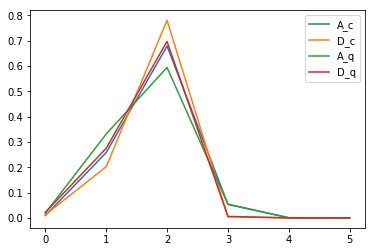

In [513]:
plt.plot(HB_edges[:-1],accept_DF/numframes/63,label="A_c")
plt.plot(HB_edges[:-1],donate_DF/numframes/63,label="D_c")
plt.plot(HB_edges[:-1],accept_DF_q/numframes_q/63,label="A_q")
plt.plot(HB_edges[:-1],donate_DF_q/numframes_q/63,label="D_q")
plt.legend()
print(numaccept/numframes/63,numdonate/numframes/63,numaccept/numframes/63+numdonate/numframes/63)
print(numaccept_q/numframes_q/63,numdonate_q/numframes_q/63,numaccept_q/numframes_q/63+numdonate_q/numframes_q/63)

In [1040]:
#calculate bonding information 
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
HB_OO_cutoff = 3.5
HB_HOO_cutoff = 30

waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes_c = 0.
num_count_c = 0.
numdonate_first_c = 0.
numaccept_first_c = 0.
accept_DF_first_c,HB_edges = np.histogram([],6,(0,6))
donate_DF_first_c,HB_edges = np.histogram([],6,(0,6))

for sn in snap_c:
    tmp_dist = sn.get_all_distances(mic=True)
    #OO_cutoff
    O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
    O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
    #avoid self angle
    O1_t2 = O1_t[np.where(O1_t!=O2_t)]
    O2_t2 = O2_t[np.where(O1_t!=O2_t)]
    #O and H fit OO cutoff
    H1 = waters[O1_t2,1]
    H2 = waters[O1_t2,2]
    O1 = waters[O1_t2,0]
    O2 = waters[O2_t2,0]
    length = len(O1)
    #calculate angles for H1 and H2 in water O1
    angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    d1 = O1[np.where(angles1<HB_HOO_cutoff)]
    a1 = O2[np.where(angles1<HB_HOO_cutoff)]
    d2 = O1[np.where(angles2<HB_HOO_cutoff)]
    a2 = O2[np.where(angles2<HB_HOO_cutoff)]
    #count the H-bond within first shell
    Os = np.where(tmp_dist[0,1:64]<3.83)[0]+1
    a_first = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
    d_first = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
    accept_DF_first_c += np.histogram(a_first,6,(0,6))[0]
    donate_DF_first_c += np.histogram(d_first,6,(0,6))[0]
    numaccept_first_c += a_first.sum()
    numdonate_first_c += d_first.sum()
    num_count_c += Os.size
    numframes_c += 1
    
#calculate bonding information quantum
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes_q = 0.
num_count_q = 0.
numdonate_first_q = 0.
numaccept_first_q = 0.
accept_DF_first_q,HB_edges = np.histogram([],6,(0,6))
donate_DF_first_q,HB_edges = np.histogram([],6,(0,6))

for beads in snap:
    for sn in beads:
        tmp_dist = sn.get_all_distances(mic=True)
        #OO_cutoff
        O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
        O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
        #avoid self angle
        O1_t2 = O1_t[np.where(O1_t!=O2_t)]
        O2_t2 = O2_t[np.where(O1_t!=O2_t)]
        #O and H fit OO cutoff
        H1 = waters[O1_t2,1]
        H2 = waters[O1_t2,2]
        O1 = waters[O1_t2,0]
        O2 = waters[O2_t2,0]
        length = len(O1)
        #calculate angles for H1 and H2 in water O1
        angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        d1 = O1[np.where(angles1<HB_HOO_cutoff)]
        a1 = O2[np.where(angles1<HB_HOO_cutoff)]
        d2 = O1[np.where(angles2<HB_HOO_cutoff)]
        a2 = O2[np.where(angles2<HB_HOO_cutoff)]
        #count the H-bond within first shell
        Os = np.where(tmp_dist[0,1:64]<3.9)[0]+1
        a_first = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
        d_first = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
        accept_DF_first_q += np.histogram(a_first,6,(0,6))[0]
        donate_DF_first_q += np.histogram(d_first,6,(0,6))[0]
        numaccept_first_q += a_first.sum()
        numdonate_first_q += d_first.sum()
        numframes_q += 1
        num_count_q += Os.size
        
HB_first_x = HB_edges[:-1]

ADA C: 1.7781556002682763 1.7781556002682763 3.5563112005365527
ADA Q: 1.6871557971014493 1.6871557971014493 3.3743115942028985
ADA C-first: 1.7022116986390352 1.073475331859566 2.7756870304986014
ADA Q-first: 1.5620396744106928 1.092012638482224 2.654052312892917
AD(include Cl) C-first: 1.7022116986390352 1.8201934057644558
AD(include Cl) Q-first: 1.5620396744106928 1.7421814773126214


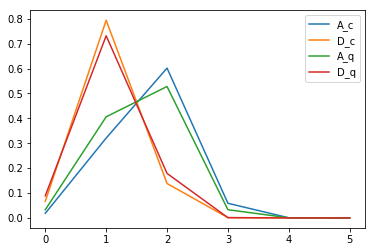

In [1044]:
plt.plot(HB_first_x,accept_DF_first_c/num_count_c,label="A_c")
plt.plot(HB_first_x,donate_DF_first_c/num_count_c,label="D_c")
plt.plot(HB_first_x,accept_DF_first_q/num_count_q,label="A_q")
plt.plot(HB_first_x,donate_DF_first_q/num_count_q,label="D_q")
plt.legend()
print("ADA C:",numaccept/numframes/63,numdonate/numframes/63,numaccept/numframes/63+numdonate/numframes/63)
print("ADA Q:",numaccept_q/numframes_q/63,numdonate_q/numframes_q/63,numaccept_q/numframes_q/63+numdonate_q/numframes_q/63)
print("ADA C-first:",numaccept_first_c/num_count_c,numdonate_first_c/num_count_c,numaccept_first_c/num_count_c+numdonate_first_c/num_count_c)
print("ADA Q-first:",numaccept_first_q/num_count_q,numdonate_first_q/num_count_q,numaccept_first_q/num_count_q+numdonate_first_q/num_count_q)
print("AD(include Cl) C-first:",numaccept_first_c/num_count_c,(numdonate_first_c+HB_Cl_count)/num_count_c)
print("AD(include Cl) Q-first:",numaccept_first_q/num_count_q,(numdonate_first_q+HB_Cl_count_q)/num_count_q)



In [1378]:
HB_HOCl_cutoff = 30
numaccept_first_clhb_c = 0
numaccept_first_nclhb_c = 0
numdonate_first_clhb_c = 0
numdonate_first_nclhb_c = 0
num_count_clhb_c = 0
num_count_nclhb_c = 0
num_count_c = 0

for sn in snap_c:
    tmp_dist = sn.get_all_distances(mic=True)
    #OO_cutoff
    O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
    O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
    #avoid self angle
    O1_t2 = O1_t[np.where(O1_t!=O2_t)]
    O2_t2 = O2_t[np.where(O1_t!=O2_t)]
    #O and H fit OO cutoff
    H1 = waters[O1_t2,1]
    H2 = waters[O1_t2,2]
    O1 = waters[O1_t2,0]
    O2 = waters[O2_t2,0]
    length = len(O1)
    #calculate angles for H1 and H2 in water O1
    angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    d1 = O1[np.where(angles1<HB_HOO_cutoff)]
    a1 = O2[np.where(angles1<HB_HOO_cutoff)]
    d2 = O1[np.where(angles2<HB_HOO_cutoff)]
    a2 = O2[np.where(angles2<HB_HOO_cutoff)]
    #count the H-bond within first shell and H-bonded
    Os_first = np.where(tmp_dist[0,1:64]<3.83)[0]+1
    H1s_first = Os_first*2 + 62
    H2s_first = Os_first*2 + 63
    length = Os_first.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s_first.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s_first.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    cl_d1 = Os_first[np.where(angles1<HB_HOCl_cutoff)]
    cl_d2 = Os_first[np.where(angles2<HB_HOCl_cutoff)]
    #Os bonded with Cl and non-bonded with Cl
    Os_clhb = np.concatenate((cl_d1,cl_d2))
    Os_nclhb = np.setdiff1d(Os_first,Os_clhb)
    #number of OO hb
    a_first_clhb = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os_clhb]
    a_first_nclhb = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os_nclhb]
    d_first_clhb = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os_clhb]
    d_first_nclhb = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os_nclhb]
    ##accept_DF_first_c += np.histogram(a_first,6,(0,6))[0]
    ##donate_DF_first_c += np.histogram(d_first,6,(0,6))[0]
    numaccept_first_clhb_c += a_first_clhb.sum()
    numaccept_first_nclhb_c += a_first_nclhb.sum()
    numdonate_first_clhb_c += d_first_clhb.sum()
    numdonate_first_nclhb_c += d_first_nclhb.sum()
    num_count_clhb_c += Os_clhb.size
    num_count_nclhb_c += Os_nclhb.size
    num_count_c += Os_first.size
    
numaccept_first_clhb_q = 0
numaccept_first_nclhb_q = 0
numdonate_first_clhb_q = 0
numdonate_first_nclhb_q = 0
num_count_clhb_q = 0
num_count_nclhb_q = 0
num_count_q = 0

for beads in snap:
    for sn in beads:
        tmp_dist = sn.get_all_distances(mic=True)
        #OO_cutoff
        O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
        O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
        #avoid self angle
        O1_t2 = O1_t[np.where(O1_t!=O2_t)]
        O2_t2 = O2_t[np.where(O1_t!=O2_t)]
        #O and H fit OO cutoff
        H1 = waters[O1_t2,1]
        H2 = waters[O1_t2,2]
        O1 = waters[O1_t2,0]
        O2 = waters[O2_t2,0]
        length = len(O1)
        #calculate angles for H1 and H2 in water O1
        angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        d1 = O1[np.where(angles1<HB_HOO_cutoff)]
        a1 = O2[np.where(angles1<HB_HOO_cutoff)]
        d2 = O1[np.where(angles2<HB_HOO_cutoff)]
        a2 = O2[np.where(angles2<HB_HOO_cutoff)]
        #count the H-bond within first shell and H-bonded
        Os_first = np.where(tmp_dist[0,1:64]<3.83)[0]+1
        H1s_first = Os_first*2 + 62
        H2s_first = Os_first*2 + 63
        length = Os_first.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s_first.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s_first.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        cl_d1 = Os_first[np.where(angles1<HB_HOCl_cutoff)]
        cl_d2 = Os_first[np.where(angles2<HB_HOCl_cutoff)]
        #Os bonded with Cl and non-bonded with Cl
        Os_clhb = np.concatenate((cl_d1,cl_d2))
        Os_nclhb = np.setdiff1d(Os_first,Os_clhb)
        #number of OO hb
        a_first_clhb = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os_clhb]
        a_first_nclhb = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os_nclhb]
        d_first_clhb = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os_clhb]
        d_first_nclhb = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os_nclhb]
        ##accept_DF_first_c += np.histogram(a_first,6,(0,6))[0]
        ##donate_DF_first_c += np.histogram(d_first,6,(0,6))[0]
        numaccept_first_clhb_q += a_first_clhb.sum()
        numaccept_first_nclhb_q += a_first_nclhb.sum()
        numdonate_first_clhb_q += d_first_clhb.sum()
        numdonate_first_nclhb_q += d_first_nclhb.sum()
        num_count_clhb_q += Os_clhb.size
        num_count_nclhb_q += Os_nclhb.size
        num_count_q += Os_first.size


In [1379]:
print("ADA C:",numaccept/numframes/63,numdonate/numframes/63,numaccept/numframes/63+numdonate/numframes/63)
print("ADA Q:",numaccept_q/numframes_q/63,numdonate_q/numframes_q/63,numaccept_q/numframes_q/63+numdonate_q/numframes_q/63)
print("ADA C-first:",numaccept_first_c/num_count_c,numdonate_first_c/num_count_c,numaccept_first_c/num_count_c+numdonate_first_c/num_count_c)
print("ADA Q-first:",numaccept_first_q/num_count_q,numdonate_first_q/num_count_q,numaccept_first_q/num_count_q+numdonate_first_q/num_count_q)
print("ADA C-first  hb:",numaccept_first_clhb_c/num_count_clhb_c,numdonate_first_clhb_c/num_count_clhb_c,numaccept_first_clhb_c/num_count_clhb_c+numdonate_first_clhb_c/num_count_clhb_c,num_count_clhb_c/num_count_c)
print("ADA C-first nhb:",numaccept_first_nclhb_c/num_count_nclhb_c,numdonate_first_nclhb_c/num_count_nclhb_c,numaccept_first_nclhb_c/num_count_nclhb_c+numdonate_first_nclhb_c/num_count_nclhb_c,num_count_nclhb_c/num_count_c)
print("ADA Q-first  hb:",numaccept_first_clhb_q/num_count_clhb_q,numdonate_first_clhb_q/num_count_clhb_q,numaccept_first_clhb_q/num_count_clhb_q+numdonate_first_clhb_q/num_count_clhb_q,num_count_clhb_q/num_count_q)
print("ADA Q-first nhb:",numaccept_first_nclhb_q/num_count_nclhb_q,numdonate_first_nclhb_q/num_count_nclhb_q,numaccept_first_nclhb_q/num_count_nclhb_q+numdonate_first_nclhb_q/num_count_nclhb_q,num_count_nclhb_q/num_count_q)
print("AD(include Cl) C-first:",numaccept_first_c/num_count_c,(numdonate_first_c+HB_Cl_count)/num_count_c)
print("AD(include Cl) Q-first:",numaccept_first_q/num_count_q,(numdonate_first_q+HB_Cl_count_q)/num_count_q)

ADA C: 1.7779051910864332 1.7779051910864332 3.5558103821728664
ADA Q: 1.6871557971014493 1.6871557971014493 3.3743115942028985
ADA C-first: 1.703217492430354 1.0737267803073958 2.77694427273775
ADA Q-first: 1.6438017032556864 1.1491719861667606 2.792973689422447
ADA C-first  hb: 1.7484037744377896 0.9301616001808114 2.678565374618601 0.7416891049482959
ADA C-first nhb: 1.5695802068545934 1.4849726221861692 3.0545528290407624 0.25831089505170407
ADA Q-first  hb: 1.5729038658834935 0.9002919987823989 2.4731958646658923 0.6756577644388245
ADA Q-first nhb: 1.5290166514009254 1.4196669719814932 2.9486836233824185 0.32434223556117553
AD(include Cl) C-first: 1.703217492430354 1.820549624398881
AD(include Cl) Q-first: 1.6438017032556864 1.833372690016606


In [1283]:
#calculate bonding information only within the 
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
HB_OO_cutoff = 3.5
HB_HOO_cutoff = 30

waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes_c = 0.
num_count_c = 0.
numdonate_first_only_c = 0.
numaccept_first_only_c = 0.
accept_DF_first_only_c,HB_edges = np.histogram([],6,(0,6))
donate_DF_first_only_c,HB_edges = np.histogram([],6,(0,6))

for sn in snap_c:
    tmp_dist = sn.get_all_distances(mic=True)
    #OCl_cutoff only in first shell
    Os = np.where(tmp_dist[0,1:64]<3.83)[0]+1
    Os_dist = tmp_dist[Os][:,Os]
    #OO_cutoff 
    O1_t,O2_t = np.where(Os_dist<HB_OO_cutoff)
    O1_t =  Os[O1_t]
    O2_t =  Os[O2_t]
    #avoid self angle
    O1s = O1_t[O1_t!=O2_t]
    O2s = O2_t[O1_t!=O2_t]
    #Hs for O1s
    H1s,H2s = water(O1s)
    length = H1s.size
    #calculate angles for H1 and H2 in water O1
    angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    d1 = O1s[np.where(angles1<HB_HOO_cutoff)]
    a1 = O2s[np.where(angles1<HB_HOO_cutoff)]
    d2 = O1s[np.where(angles2<HB_HOO_cutoff)]
    a2 = O2s[np.where(angles2<HB_HOO_cutoff)]
    a_first_only = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
    d_first_only = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
    accept_DF_first_only_c += np.histogram(a_first_only,6,(0,6))[0]
    donate_DF_first_only_c += np.histogram(d_first_only,6,(0,6))[0]
    numaccept_first_only_c += a_first_only.sum()
    numdonate_first_only_c += d_first_only.sum()
    num_count_c += Os.size
    numframes_c += 1
    
#calculate bonding information quantum
#assuming ith(0-63) water is (1+i,64+i*2,65+i*2)
waters = np.concatenate((np.arange(1,64).reshape(63,1),np.arange(64,190,2).reshape(63,1),np.arange(65,190,2).reshape(63,1)),axis=1)
numframes_q = 0.
num_count_q = 0.
numdonate_first_only_q = 0.
numaccept_first_only_q = 0.
accept_DF_first_only_q,HB_edges = np.histogram([],6,(0,6))
donate_DF_first_only_q,HB_edges = np.histogram([],6,(0,6))

for beads in snap:
    for sn in beads:
        tmp_dist = sn.get_all_distances(mic=True)
        #OCl_cutoff only in first shell
        Os = np.where(tmp_dist[0,1:64]<3.9)[0]+1
        Os_dist = tmp_dist[Os][:,Os]
        #OO_cutoff 
        O1_t,O2_t = np.where(Os_dist<HB_OO_cutoff)
        O1_t =  Os[O1_t]
        O2_t =  Os[O2_t]
        #avoid self angle
        O1s = O1_t[O1_t!=O2_t]
        O2s = O2_t[O1_t!=O2_t]
        #Hs for O1s
        H1s,H2s = water(O1s)
        length = H1s.size
        #calculate angles for H1 and H2 in water O1
        angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        d1 = O1s[np.where(angles1<HB_HOO_cutoff)]
        a1 = O2s[np.where(angles1<HB_HOO_cutoff)]
        d2 = O1s[np.where(angles2<HB_HOO_cutoff)]
        a2 = O2s[np.where(angles2<HB_HOO_cutoff)]
        a_first_only = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
        d_first_only = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
        accept_DF_first_only_q += np.histogram(a_first_only,6,(0,6))[0]
        donate_DF_first_only_q += np.histogram(d_first_only,6,(0,6))[0]
        numaccept_first_only_q += a_first_only.sum()
        numdonate_first_only_q += d_first_only.sum()
        num_count_q += Os.size
        numframes_q += 1
        
HB_first_x = HB_edges[:-1]

ADA C: 1.7781556002682763 1.7781556002682763 3.5563112005365527
ADA Q: 1.6871557971014493 1.6871557971014493 3.3743115942028985
ADA C-first: 1.7022116986390352 1.073475331859566 2.7756870304986014
ADA Q-first: 1.5620396744106928 1.092012638482224 2.654052312892917
ADA C-first only: 0.15056523515668382 0.15056523515668382 0.30113047031336765
ADA Q-first only: 0.17453193822634175 0.17453193822634175 0.3490638764526835
AD(include Cl) C-first: 1.7022116986390352 1.8201934057644558
AD(include Cl) Q-first: 1.5620396744106928 1.7421814773126214


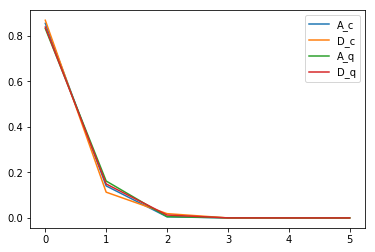

In [1284]:
plt.plot(HB_first_x,accept_DF_first_only_c/num_count_c,label="A_c")
plt.plot(HB_first_x,donate_DF_first_only_c/num_count_c,label="D_c")
plt.plot(HB_first_x,accept_DF_first_only_q/num_count_q,label="A_q")
plt.plot(HB_first_x,donate_DF_first_only_q/num_count_q,label="D_q")
plt.legend()
print("ADA C:",numaccept/numframes/63,numdonate/numframes/63,numaccept/numframes/63+numdonate/numframes/63)
print("ADA Q:",numaccept_q/numframes_q/63,numdonate_q/numframes_q/63,numaccept_q/numframes_q/63+numdonate_q/numframes_q/63)
print("ADA C-first:",numaccept_first_c/num_count_c,numdonate_first_c/num_count_c,numaccept_first_c/num_count_c+numdonate_first_c/num_count_c)
print("ADA Q-first:",numaccept_first_q/num_count_q,numdonate_first_q/num_count_q,numaccept_first_q/num_count_q+numdonate_first_q/num_count_q)
print("ADA C-first only:",numaccept_first_only_c/num_count_c,numdonate_first_only_c/num_count_c,numaccept_first_only_c/num_count_c+numdonate_first_only_c/num_count_c)
print("ADA Q-first only:",numaccept_first_only_q/num_count_q,numdonate_first_only_q/num_count_q,numaccept_first_only_q/num_count_q+numdonate_first_only_q/num_count_q)
print("AD(include Cl) C-first:",numaccept_first_c/num_count_c,(numdonate_first_c+HB_Cl_count)/num_count_c)
print("AD(include Cl) Q-first:",numaccept_first_q/num_count_q,(numdonate_first_q+HB_Cl_count_q)/num_count_q)

# water - cl H-bond

In [962]:
#calculate H-bond in first shell between H and Cl
#define H-bond between Cl and water: Cl-O<3.9 H-O-Cl <30
HB_HOCl_cutoff = 30
HB_OCl_cutoff = 3.9

cn_HB,cn_edges = np.histogram([],11,(0,11))
numframes = 0.
HB_Cl_count = 0 

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    #waters
    Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
    d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
    cn_HB += np.histogram(d1.size + d2.size,11,(0,11))[0]
    numframes += 1
    HB_Cl_count += d1.size + d2.size
    
cn_HB_x = cn_edges[:-1]
cn_HB_c = cn_HB

#calculate shift of hydration box center in snapshot with >=3 115-125 angles_q
cn_HB_q,cn_edges = np.histogram([],11,(0,11))
numframes_q = 0.
HB_Cl_count_q = 0 

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        #waters
        Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        length = Os.size
        #Cl-O-H angles
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
        d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
        cn_HB_q += np.histogram(d1.size + d2.size,11,(0,11))[0]
        numframes_q += 1
        HB_Cl_count_q += d1.size + d2.size
    

C-HB:  5.019154929577465
Q-HB:  4.881548913043479


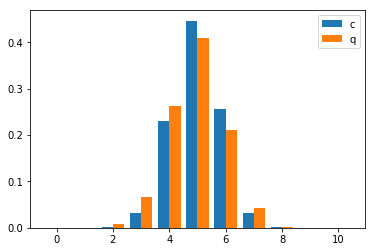

In [963]:
plt.bar(cn_HB_x,cn_HB_c/numframes,-0.4,align='edge',label="c")
plt.bar(cn_HB_x,cn_HB_q/numframes_q,0.4,align='edge',label="q")
plt.legend()
print("C-HB: ",HB_Cl_count/numframes)
print("Q-HB: ",HB_Cl_count_q/numframes_q)

In [1365]:
#calculate H-bond in first shell between H and Cl
#define H-bond between Cl and water: Cl-O<3.9 H-O-Cl <50
HB_HOCl_cutoff2 = 50
HB_OCl_cutoff = 3.9

cn_HB,cn_edges = np.histogram([],11,(0,11))
numframes = 0.
HB_Cl_count2 = 0 

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    #waters
    Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1<HB_HOCl_cutoff2)]
    d2 = Os[np.where(angles2<HB_HOCl_cutoff2)]
    cn_HB += np.histogram(d1.size + d2.size,11,(0,11))[0]
    numframes += 1
    HB_Cl_count2 += d1.size + d2.size
    
cn_HB_x = cn_edges[:-1]
cn_HB_c2 = cn_HB

#calculate shift of hydration box center in snapshot with >=3 115-125 angles_q
cn_HB_q2,cn_edges = np.histogram([],11,(0,11))
numframes_q = 0.
HB_Cl_count_q2 = 0 

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        #waters
        Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        length = Os.size
        #Cl-O-H angles
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1<HB_HOCl_cutoff2)]
        d2 = Os[np.where(angles2<HB_HOCl_cutoff2)]
        cn_HB_q2 += np.histogram(d1.size + d2.size,11,(0,11))[0]
        numframes_q += 1
        HB_Cl_count_q2 += d1.size + d2.size
    

C-HB:  5.9305027460921
Q-HB:  6.095896739130435


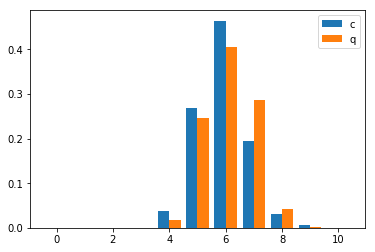

In [1383]:
plt.bar(cn_HB_x,cn_HB_c2/numframes,-0.4,align='edge',label="c")
plt.bar(cn_HB_x,cn_HB_q2/numframes_q,0.4,align='edge',label="q")
plt.legend()
print("C-HB: ",HB_Cl_count2/numframes)
print("Q-HB: ",HB_Cl_count_q2/numframes_q)

## H-bonded water OClO distribution

In [ ]:
#Calculate the OClO distribution of bonded O's
#calculate H-bond in first shell between H and Cl
#define H-bond between Cl and water: Cl-O<3.9 H-O-Cl <30
HB_HOCl_cutoff = 30
HB_OCl_cutoff = 3.9

rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    #waters
    Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
    d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(np.concatenate((d1,d2)),2))),1,0,axis=1),mic=True)
    rdf += np.histogram(angles,500,(0,180))[0]
    pointscount += angles.size

rdf.astype(np.float64)
G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
G_OClO_BH_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        #waters
        Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        length = Os.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
        d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
        if(d1.size + d2.size > 1):
            angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(np.concatenate((d1,d2)),2))),1,0,axis=1),mic=True)
            rdf += np.histogram(angles,500,(0,180))[0]
            pointscount += angles.size

rdf.astype(np.float64)
G_OClO_HB_q = rdf/pointscount/vol
    

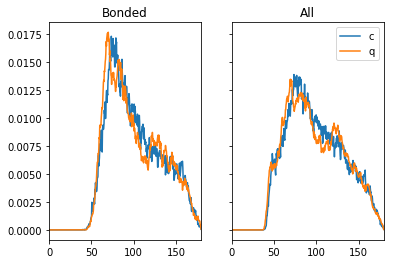

In [1014]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].plot(G_OClO_x,G_OClO_BH_c,label="c")
ax[0].plot(G_OClO_x,G_OClO_HB_q,label="q")
ax[0].set_xlim(0,180)
ax[0].set_title("Bonded")
ax[1].plot(G_OClO_x,G_ClO_c,label="c")
ax[1].plot(G_OClO_x,G_ClO_q,label="q")
ax[1].set_xlim(0,180)
ax[1].set_title("All")
plt.legend()

In [1274]:
#Calculate the OClO distribution of bonded O's
#calculate H-bond in first shell between H and Cl
#define H-bond between Cl and water: Cl-O<3.9 H-O-Cl <30
HB_HOCl_cutoff = 30
HB_OCl_cutoff = 3.9

G_OClO_HB_cn_c = []
G_OClO_HB_cn_q = []
for i in range(10):
    G_OClO_HB_cn_c.append(DF(500,(0,180)))
    G_OClO_HB_cn_q.append(DF(500,(0,180)))

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    #waters
    Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
    H1s,H2s = water(Os)
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
    d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
    Os = np.concatenate((d1,d2))
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    G_OClO_HB_cn_c[Os.size].read(angles)


for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        #waters
        Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
        H1s,H2s = water(Os)
        length = Os.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1<HB_HOCl_cutoff)]
        d2 = Os[np.where(angles2<HB_HOCl_cutoff)]
        Os = np.concatenate((d1,d2))
        if(Os.size>1):
            angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
            G_OClO_HB_cn_q[Os.size].read(angles)

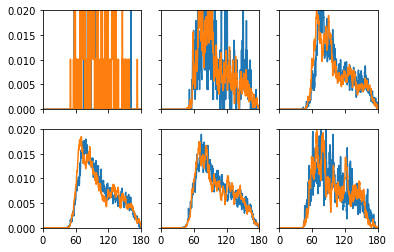

In [1279]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
plt.setp(ax, xticks=[0, 60, 120,180])
for i in range(2):
    for j in range(3):
        k=i*3+j+2
        ax[i][j].plot(G_OClO_HB_cn_c[k].get_x(),G_OClO_HB_cn_c[k].get_y(),label="c"+str(k))
        ax[i][j].plot(G_OClO_HB_cn_q[k].get_x(),G_OClO_HB_cn_q[k].get_y(),label="q"+str(k))
        ax[i][j].set_xlim((0,180))
        ax[i][j].set_ylim((0,0.02))
        

In [1192]:
#Calculate the OClO distribution of non bonded O's
#calculate H-bond in first shell between H and Cl
#define H-bond between Cl and water: Cl-O<3.9 H-O-Cl <30
HB_HOCl_cutoff = 30
HB_OCl_cutoff = 3.9

rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    #waters
    Os = np.where(dOCl_all<3.83)[0]+1
    H1s = Os*2 + 62
    H2s = Os*2 + 63
    length = Os.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    d1 = Os[np.where(angles1>HB_HOCl_cutoff)]
    d2 = Os[np.where(angles2>HB_HOCl_cutoff)]
    Os = np.intersect1d(d1,d2)
    if(Os.size > 1):
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        rdf += np.histogram(angles,500,(0,180))[0]
        pointscount += angles.size

rdf.astype(np.float64)
G_OClO_x = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
G_OClO_nHB_c = rdf/pointscount/vol

rdf,edges = np.histogram([],500,(0,180))
pointscount = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        #waters
        Os = np.where(dOCl_all<HB_OCl_cutoff)[0]+1
        H1s = Os*2 + 62
        H2s = Os*2 + 63
        length = Os.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        d1 = Os[np.where(angles1>HB_HOCl_cutoff)]
        d2 = Os[np.where(angles2>HB_HOCl_cutoff)]
        Os = np.intersect1d(d1,d2)
        if(Os.size > 1):
            angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
            rdf += np.histogram(angles,500,(0,180))[0]
            pointscount += angles.size

rdf.astype(np.float64)
G_OClO_nHB_q = rdf/pointscount/vol
    

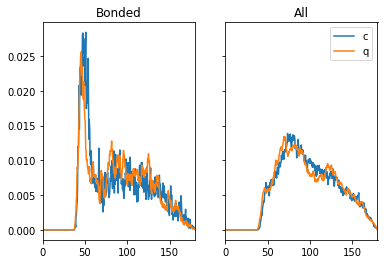

In [1193]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].plot(G_OClO_x,G_OClO_nHB_c,label="c")
ax[0].plot(G_OClO_x,G_OClO_nHB_q,label="q")
ax[0].set_xlim(0,180)
ax[0].set_title("Bonded")
ax[1].plot(G_OClO_x,G_ClO_c,label="c")
ax[1].plot(G_OClO_x,G_ClO_q,label="q")
ax[1].set_xlim(0,180)
ax[1].set_title("All")
plt.legend()

## water - hbonded water  OClO distribution

In [1520]:
HB_OO_cutoff = 3.5
HB_HOO_cutoff = 30

D_OClO_wHB_c = DF(500,(0,180))
D_OClO_wHB_q = DF(500,(0,180))

sn = snap[1][679]
tmp_dist = sn.get_all_distances(mic=True)
#OO_cutoff
O1s,O2s = np.where((tmp_dist[1:64,1:64]<HB_OO_cutoff)&(tmp_dist[1:64,1:64]>0))
#O and H fit OO cutoff
O1s = O1s + 1
O2s = O2s + 1
H1s,H2s = water(O1s)
length = O1s.size
#calculate angles for H1 and H2 in water O1
angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
d1 = O1s[np.where(angles1<HB_HOO_cutoff)]
a1 = O2s[np.where(angles1<HB_HOO_cutoff)]
d2 = O1s[np.where(angles2<HB_HOO_cutoff)]
a2 = O2s[np.where(angles2<HB_HOO_cutoff)]
Os = np.where(tmp_dist[0,1:64]<3.9)[0]+1
a_first = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
d_first = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
#if(Os.size > 1):
#    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
#    rdf += np.histogram(angles,500,(0,180))[0]
#    pointscount += angles.size
Os,a_first,d_first

(array([ 4,  7, 15, 27, 31, 44, 50, 58, 61, 63]),
 array([2, 2, 1, 1, 0, 1, 2, 1, 0, 1]),
 array([0, 1, 1, 0, 0, 2, 2, 2, 1, 0]))

# H2O OH orientations
## Cl-O-H angle in first shell

In [1481]:
# not H2O bisector and O-Cl angle distribution
D_ClOH_c = DF(500,(0,180))
D_ClOH_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    dOCl_all  = sn.get_distances(0,Os,mic=True)
    Os_first = np.where(dOCl_all<3.83)[0]+1
    H1s,H2s = water(Os_first)
    length = Os_first.size
    angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
    D_ClOH_c.read(angles1)
    D_ClOH_c.read(angles2)

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        dOCl_all  = sn.get_distances(0,Os,mic=True)
        Os_first = np.where(dOCl_all<3.9)[0]+1
        H1s,H2s = water(Os_first)
        length = Os_first.size
        angles1 = sn.get_angles(np.insert(np.concatenate((H1s.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        angles2 = sn.get_angles(np.insert(np.concatenate((H2s.reshape(length,1),Os_first.reshape(length,1)),axis=1),2,0,axis=1),mic=True)
        D_ClOH_q.read(angles1)
        D_ClOH_q.read(angles2)
    


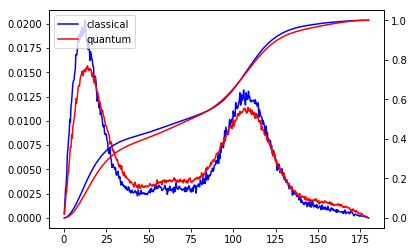

In [1482]:
#D_ClOH_c.plot("c")
#D_ClOH_q.plot("q")
fig, ax1 = plt.subplots()
ax1.plot(D_ClOH_c.get_x(),D_ClOH_c.get_y(),'-',color='blue',label='classical')
ax1.plot(D_ClOH_q.get_x(),D_ClOH_q.get_y(),'-',color='red',label='quantum')
ax2 = ax1.twinx()
ax2.plot(D_ClOH_c.get_x(),np.cumsum(D_ClOH_c.get_y()*180/500),'-',color='blue',label='classical')
ax2.plot(D_ClOH_q.get_x(),np.cumsum(D_ClOH_q.get_y()*180/500),'-',color='red',label='quantum')
plt.legend()
#D_ClOH_c.get_y().sum(),D_ClOH_q.get_y().sum()

## O---O-H angle in first shell

In [1485]:
D_OOH_c = DF(500,(0,180))
D_OOH_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    d_all  = sn.get_all_distances(mic=True)
    Os_first = np.where(d_all[0,1:64]<3.83)[0]+1
    O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
    O1s = Os_first[O1s]
    O2s = O2s + 1
    H1s,H2s = water(O1s)
    length = O1s.size
    angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    D_OOH_c.read(angles1)
    D_OOH_c.read(angles2)
    
for beads in snap:
    for sn in beads:
        Os = range(1,64)
        d_all  = sn.get_all_distances(mic=True)
        Os_first = np.where(d_all[0,1:64]<3.83)[0]+1
        O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
        O1s = Os_first[O1s]
        O2s = O2s + 1
        H1s,H2s = water(O1s)
        length = O1s.size
        angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        D_OOH_q.read(angles1)
        D_OOH_q.read(angles2)

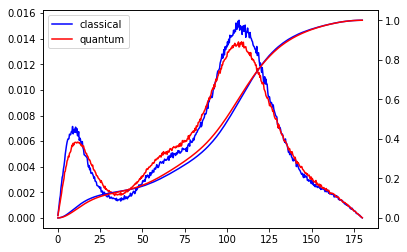

In [1486]:
fig, ax1 = plt.subplots()
ax1.plot(D_OOH_c.get_x(),D_OOH_c.get_y(),'-',color='blue',label='classical')
ax1.plot(D_OOH_q.get_x(),D_OOH_q.get_y(),'-',color='red',label='quantum')
ax2 = ax1.twinx()
ax2.plot(D_OOH_c.get_x(),np.cumsum(D_OOH_c.get_y()*180/500),'-',color='blue',label='classical')
ax2.plot(D_OOH_q.get_x(),np.cumsum(D_OOH_q.get_y()*180/500),'-',color='red',label='quantum')
plt.legend()

In [22]:
D_OOH_3d4_c = DF(500,(0,180))
D_OOH_3d4_q = DF(500,(0,180))
D_OOH_3d4to3d83_c = DF(500,(0,180))
D_OOH_3d4to3d83_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    d_all  = sn.get_all_distances(mic=True)
    Os_first = np.where(d_all[0,1:64]<3.4)[0]+1
    O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
    O1s = Os_first[O1s]
    O2s = O2s + 1
    H1s,H2s = water(O1s)
    length = O1s.size
    angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    D_OOH_3d4_c.read(angles1)
    D_OOH_3d4_c.read(angles2)
    Os_first = np.where((d_all[0,1:64]>3.4)&(d_all[0,1:64]<3.83))[0]+1
    O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
    O1s = Os_first[O1s]
    O2s = O2s + 1
    H1s,H2s = water(O1s)
    length = O1s.size
    angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    D_OOH_3d4to3d83_c.read(angles1)
    D_OOH_3d4to3d83_c.read(angles2)
    
for beads in snap:
    for sn in beads:
        Os = range(1,64)
        d_all  = sn.get_all_distances(mic=True)
        Os_first = np.where(d_all[0,1:64]<3.4)[0]+1
        O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
        O1s = Os_first[O1s]
        O2s = O2s + 1
        H1s,H2s = water(O1s)
        length = O1s.size
        angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        D_OOH_3d4_q.read(angles1)
        D_OOH_3d4_q.read(angles2)
        Os_first = np.where((d_all[0,1:64]>3.4)&(d_all[0,1:64]<3.83))[0]+1
        O1s,O2s = np.where((d_all[Os_first,1:64]<3.5)&(d_all[Os_first,1:64]>0))
        O1s = Os_first[O1s]
        O2s = O2s + 1
        H1s,H2s = water(O1s)
        length = O1s.size
        angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        D_OOH_3d4to3d83_q.read(angles1)
        D_OOH_3d4to3d83_q.read(angles2)

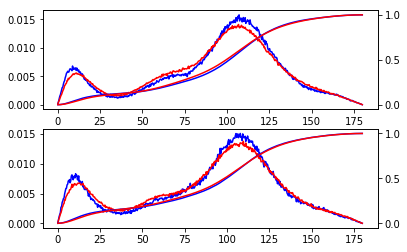

In [24]:
fig, ax1 = plt.subplots(2)
ax1[0].plot(D_OOH_3d4_c.get_x(),D_OOH_3d4_c.get_y(),'-',color='blue',label='classical')
ax1[0].plot(D_OOH_3d4_q.get_x(),D_OOH_3d4_q.get_y(),'-',color='red',label='quantum')
ax2 = ax1[0].twinx()
ax2.plot(D_OOH_3d4_c.get_x(),np.cumsum(D_OOH_3d4_c.get_y()*180/500),'-',color='blue',label='classical')
ax2.plot(D_OOH_3d4_q.get_x(),np.cumsum(D_OOH_3d4_q.get_y()*180/500),'-',color='red',label='quantum')
ax1[1].plot(D_OOH_3d4to3d83_c.get_x(),D_OOH_3d4to3d83_c.get_y(),'-',color='blue',label='classical')
ax1[1].plot(D_OOH_3d4to3d83_q.get_x(),D_OOH_3d4to3d83_q.get_y(),'-',color='red',label='quantum')
ax2 = ax1[1].twinx()
ax2.plot(D_OOH_3d4to3d83_c.get_x(),np.cumsum(D_OOH_3d4to3d83_c.get_y()*180/500),'-',color='blue',label='classical')
ax2.plot(D_OOH_3d4to3d83_q.get_x(),np.cumsum(D_OOH_3d4to3d83_q.get_y()*180/500),'-',color='red',label='quantum')
#fig.legend()

19.557042253521125

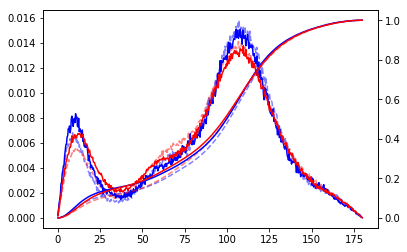

In [31]:
fig, ax1 = plt.subplots()
ax1.plot(D_OOH_3d4_c.get_x(),D_OOH_3d4_c.get_y(),'--',color='blue',label='classical',alpha=0.5)
ax1.plot(D_OOH_3d4_q.get_x(),D_OOH_3d4_q.get_y(),'--',color='red',label='quantum',alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(D_OOH_3d4_c.get_x(),np.cumsum(D_OOH_3d4_c.get_y()*180/500),'--',color='blue',label='classical',alpha=0.5)
ax2.plot(D_OOH_3d4_q.get_x(),np.cumsum(D_OOH_3d4_q.get_y()*180/500),'--',color='red',label='quantum',alpha=0.5)
ax1.plot(D_OOH_3d4to3d83_c.get_x(),D_OOH_3d4to3d83_c.get_y(),'-',color='blue',label='classical')
ax1.plot(D_OOH_3d4to3d83_q.get_x(),D_OOH_3d4to3d83_q.get_y(),'-',color='red',label='quantum')
ax2.plot(D_OOH_3d4to3d83_c.get_x(),np.cumsum(D_OOH_3d4to3d83_c.get_y()*180/500),'-',color='blue',label='classical')
ax2.plot(D_OOH_3d4to3d83_q.get_x(),np.cumsum(D_OOH_3d4to3d83_q.get_y()*180/500),'-',color='red',label='quantum')
#fig.legend()
#D_OOH_3d4to3d83_c.df.sum()/D_OOH_3d4_c.df.sum(),D_OOH_3d4to3d83_q.df.sum()/D_OOH_3d4_q.df.sum()

In [1493]:
D_OOH_all_c = DF(500,(0,180))
D_OOH_all_q = DF(500,(0,180))

for sn in snap_c:
    Os = range(1,64)
    d_all  = sn.get_all_distances(mic=True)
    O1s,O2s = np.where((d_all[1:64,1:64]<3.5)&(d_all[1:64,1:64]>0))
    O1s = O1s + 1
    O2s = O2s + 1
    H1s,H2s = water(O1s)
    length = O1s.size
    angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
    D_OOH_all_c.read(angles1)
    D_OOH_all_c.read(angles2)
    
for beads in snap:
    for sn in beads:
        Os = range(1,64)
        d_all  = sn.get_all_distances(mic=True)
        O1s,O2s = np.where((d_all[1:64,1:64]<3.5)&(d_all[1:64,1:64]>0))
        O1s = O1s + 1
        O2s = O2s + 1
        H1s,H2s = water(O1s)
        length = O1s.size
        angles1 = sn.get_angles(np.concatenate((H1s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2s.reshape(length,1),O1s.reshape(length,1),O2s.reshape(length,1)),axis=1),mic=True)
        D_OOH_all_q.read(angles1)
        D_OOH_all_q.read(angles2)

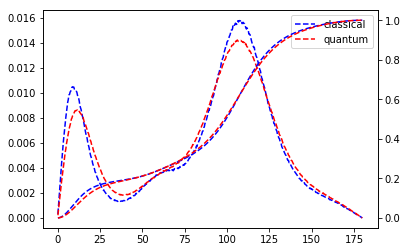

In [1502]:
fig, ax1 = plt.subplots()
ax1.plot(D_OOH_all_c.get_x(),D_OOH_all_c.get_y(),'--',color='blue',label='classical')
ax1.plot(D_OOH_all_q.get_x(),D_OOH_all_q.get_y(),'--',color='red',label='quantum')
#ax1.plot(D_OOH_c.get_x(),D_OOH_c.get_y(),'-',color='blue',label='classical')
#ax1.plot(D_OOH_q.get_x(),D_OOH_q.get_y(),'-',color='red',label='quantum')
ax2 = ax1.twinx()
ax2.plot(D_OOH_all_c.get_x(),np.cumsum(D_OOH_all_c.get_y()*180/500),'--',color='blue',label='classical')
ax2.plot(D_OOH_all_q.get_x(),np.cumsum(D_OOH_all_q.get_y()*180/500),'--',color='red',label='quantum')
#ax2.plot(D_OOH_c.get_x(),np.cumsum(D_OOH_c.get_y()*180/500),'-',color='blue',label='classical')
#ax2.plot(D_OOH_q.get_x(),np.cumsum(D_OOH_q.get_y()*180/500),'-',color='red',label='quantum')
ax1.legend()


# G_OO in the first shell

In [ ]:
#the rdf_OO in first shell
rdf,edges = np.histogram([],500,(0,8))
pointscount = 0.
pointscounts = []
rdfs = []
for i in range(11):
    rdfs.append(rdf.copy())
    pointscounts.append(0)
numframes = 0.


for sn in snap_c:
    tmp = sn.get_all_distances(mic=True)
    Os = np.where(tmp[0,1:64]<3.83)[0]+1
    rdf_data = tmp[Os][:,Os]
    rdf_data = rdf_data[np.where(rdf_data!=0)]
    numframes += 1
    tmp_hist = np.histogram(rdf_data,500,(0,8))[0]
    rdf += tmp_hist
    pointscount += len(rdf_data)
    nO = len(Os)
    if( nO < 11):
        rdfs[nO] += tmp_hist
        pointscounts[nO] += len(rdf_data)
        

rdf.astype(np.float64)
radii2 = 0.5 * (edges[1:] + edges[:-1])
rdf_inshell = rdf/pointscount
#rdf_inshells = np.asarray(rdfs)/np.asarray(pointscounts)
rdf_inshells = np.asarray(rdfs)/np.asarray(pointscounts).reshape(11,1)

In [592]:
#the rdf_OO in first shell
"""
rdf,edges = np.histogram([],500,(0,8))
numframes = 0.
pointscount = 0.

for beads in snap:
    for sn in beads:
        tmp = sn.get_all_distances(mic=True)
        Os = np.where(tmp[0,1:64]<3.9)[0]+1
        rdf_data = tmp[Os][:,Os]
        rdf_data = rdf_data[np.where(rdf_data!=0)]
        numframes += 1
        pointscount += len(rdf_data)
        rdf+=np.histogram(rdf_data,500,(0,8))[0]
        
rdf.astype(np.float64)
radii2 = 0.5 * (edges[1:] + edges[:-1])
rdf_inshell_q = rdf/pointscount
"""
rdf,edges = np.histogram([],500,(0,8))
pointscount = 0.
pointscounts = []
rdfs = []
for i in range(11):
    rdfs.append(rdf.copy())
    pointscounts.append(0)
numframes = 0.


for beads in snap:
    for sn in beads:
        tmp = sn.get_all_distances(mic=True)
        Os = np.where(tmp[0,1:64]<3.83)[0]+1
        rdf_data = tmp[Os][:,Os]
        rdf_data = rdf_data[np.where(rdf_data!=0)]
        numframes += 1
        tmp_hist = np.histogram(rdf_data,500,(0,8))[0]
        rdf += tmp_hist
        pointscount += len(rdf_data)
        nO = len(Os)
        if( nO < 11):
            rdfs[nO] += tmp_hist
            pointscounts[nO] += len(rdf_data)
        

rdf.astype(np.float64)
radii2 = 0.5 * (edges[1:] + edges[:-1])
rdf_inshell_q = rdf/pointscount
#rdf_inshells = np.asarray(rdfs)/np.asarray(pointscounts)
rdf_inshells_q = np.asarray(rdfs)/np.asarray(pointscounts).reshape(11,1)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


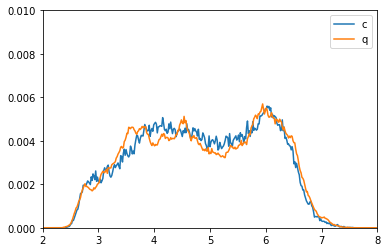

In [1251]:
plt.ylim(0,0.01)
plt.xlim(2,8)
plt.plot(radii2,rdf_inshell,label="c")
plt.plot(radii2,rdf_inshell_q,label="q")
plt.legend()

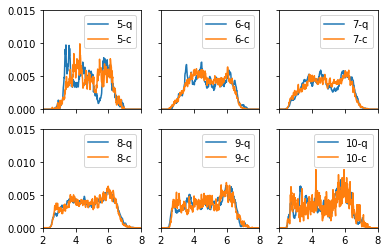

In [595]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
for i in {0,1}:
    for j in {0,1,2}: 
        ax[i,j].plot(radii2,rdf_inshells_q[5+i*3+j],label=str(5+i*3+j)+"-q")
        ax[i,j].plot(radii2,rdf_inshells[5+i*3+j],label=str(5+i*3+j)+"-c")
        ax[i,j].set_xlim(2,8)
        ax[i,j].set_ylim(0,0.015)
        ax[i,j].legend()


## G_OO as a function of HB in first shell

In [1305]:
rdf_inshells_nDHB1_c = DF(500,(0,8)) #D<1.1
rdf_inshells_nDHB2_c = DF(500,(0,8)) #D>1.1
rdf_inshells_nDHB1_q = DF(500,(0,8))
rdf_inshells_nDHB2_q = DF(500,(0,8))

for sn in snap_c:
    tmp_dist = sn.get_all_distances(mic=True)
    #OO_cutoff
    O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
    O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
    #avoid self angle
    O1_t2 = O1_t[np.where(O1_t!=O2_t)]
    O2_t2 = O2_t[np.where(O1_t!=O2_t)]
    #O and H fit OO cutoff
    H1 = waters[O1_t2,1]
    H2 = waters[O1_t2,2]
    O1 = waters[O1_t2,0]
    O2 = waters[O2_t2,0]
    length = len(O1)
    #calculate angles for H1 and H2 in water O1
    angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
    d1 = O1[np.where(angles1<HB_HOO_cutoff)]
    a1 = O2[np.where(angles1<HB_HOO_cutoff)]
    d2 = O1[np.where(angles2<HB_HOO_cutoff)]
    a2 = O2[np.where(angles2<HB_HOO_cutoff)]
    #count the H-bond within first shell
    Os = np.where(tmp_dist[0,1:64]<3.83)[0]+1
    #a_first = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
    d_first = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
    #a_first.sum()/Os.size,d_first.sum()/Os.size
    rdf_data = tmp_dist[Os][:,Os]
    rdf_data = rdf_data[rdf_data!=0]
    if(d_first.sum()/Os.size>1.1): 
        rdf_inshells_nDHB1_c.read(rdf_data)
    else:
        rdf_inshells_nDHB2_c.read(rdf_data)

for beads in snap:
    for sn in beads:
        tmp_dist = sn.get_all_distances(mic=True)
        #OO_cutoff
        O1_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[0]
        O2_t = np.where(tmp_dist[1:64,1:64]<HB_OO_cutoff)[1]
        #avoid self angle
        O1_t2 = O1_t[np.where(O1_t!=O2_t)]
        O2_t2 = O2_t[np.where(O1_t!=O2_t)]
        #O and H fit OO cutoff
        H1 = waters[O1_t2,1]
        H2 = waters[O1_t2,2]
        O1 = waters[O1_t2,0]
        O2 = waters[O2_t2,0]
        length = len(O1)
        #calculate angles for H1 and H2 in water O1
        angles1 = sn.get_angles(np.concatenate((H1.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        angles2 = sn.get_angles(np.concatenate((H2.reshape(length,1),O1.reshape(length,1),O2.reshape(length,1)),axis=1),mic=True)
        d1 = O1[np.where(angles1<HB_HOO_cutoff)]
        a1 = O2[np.where(angles1<HB_HOO_cutoff)]
        d2 = O1[np.where(angles2<HB_HOO_cutoff)]
        a2 = O2[np.where(angles2<HB_HOO_cutoff)]
        #count the H-bond within first shell
        Os = np.where(tmp_dist[0,1:64]<3.83)[0]+1
        #a_first = (np.bincount(a1,minlength=64)+np.bincount(a2,minlength=64))[Os]
        d_first = (np.bincount(d1,minlength=64)+np.bincount(d2,minlength=64))[Os]
        #a_first.sum()/Os.size,d_first.sum()/Os.size
        rdf_data = tmp_dist[Os][:,Os]
        rdf_data = rdf_data[rdf_data!=0]
        if(d_first.sum()/Os.size>1.1): 
            rdf_inshells_nDHB1_q.read(rdf_data)
        else:
            rdf_inshells_nDHB2_q.read(rdf_data)


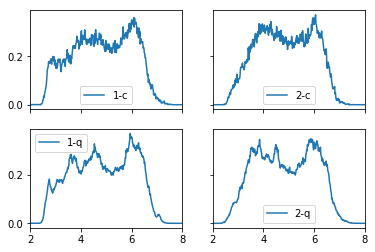

In [1308]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
ax[0,0].plot(rdf_inshells_nDHB1_c.get_x(),rdf_inshells_nDHB1_c.get_y(),label="1-c")
ax[0,1].plot(rdf_inshells_nDHB2_c.get_x(),rdf_inshells_nDHB2_c.get_y(),label="2-c")
ax[1,0].plot(rdf_inshells_nDHB1_q.get_x(),rdf_inshells_nDHB1_q.get_y(),label="1-q")
ax[1,1].plot(rdf_inshells_nDHB2_q.get_x(),rdf_inshells_nDHB2_q.get_y(),label="2-q")
for i in {0,1}:
    for j in {0,1}: 
        ax[i,j].set_xlim(2,8)
        #ax[i,j].set_ylim(0,0.015)
        ax[i,j].legend()

In [1117]:
#calculate shift of hydration box center
rdf,edges = np.histogram([],200,(0,2))
numframes = 0.
pointscounts = []
rdfs = []
for i in range(11):
    rdfs.append(rdf.copy())
    pointscounts.append(0)

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.8)[0]+1
    dis = sn.get_distances(0,Os,mic=True,vector=True)
    tmp_hist = np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
    rdf+=tmp_hist
    numframes += 1
    nO = len(Os)
    if(nO < 11):
        rdfs[nO]+=tmp_hist
        pointscounts[nO] += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
# normalization to the average density n/boxvolume in the simulation
center_shift = rdf/numframes/vol
center_shifts = np.asarray(rdfs)/np.asarray(pointscounts).reshape(11,1)/vol

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [1115]:
rdf,edges = np.histogram([],200,(0,2))
numframes = 0.
pointscounts = []
rdfs = []
for i in range(11):
    rdfs.append(rdf.copy())
    pointscounts.append(0)

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.8)[0]+1
        dis = sn.get_distances(0,Os,mic=True,vector=True)
        tmp_hist = np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
        rdf+=tmp_hist
        numframes += 1
        nO = len(Os)
        if(nO < 11):
            rdfs[nO]+=tmp_hist
            pointscounts[nO] += 1

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
vol = edges[1:] - edges[:-1]
# normalization to the average density n/boxvolume in the simulation
center_shift_q = rdf/numframes/vol
center_shifts_q = np.asarray(rdfs)/np.asarray(pointscounts).reshape(11,1)/vol

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


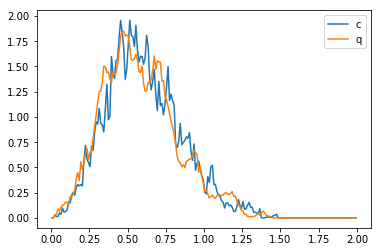

In [1118]:
plt.plot(radii,center_shift,label="c")
plt.plot(radii,center_shift_q,label="q")
plt.legend()


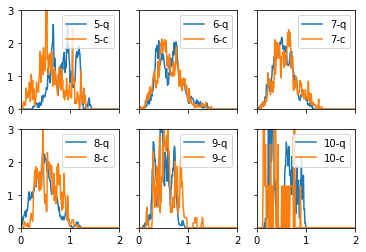

In [652]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
for i in {0,1}:
    for j in {0,1,2}: 
        ax[i,j].plot(radii,center_shifts_q[5+i*3+j],label=str(5+i*3+j)+"-q")
        ax[i,j].plot(radii,center_shifts[5+i*3+j],label=str(5+i*3+j)+"-c")
        ax[i,j].set_xlim(0,2)
        ax[i,j].set_ylim(0,3)
        ax[i,j].legend()


# Angles

## number of anlges within (115,125)

In [834]:
#calculate number of anlges within (115,125)
rdf,edges = np.histogram([],10,(0,10))
numframes = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    tmp_angle = angles[np.where(angles<125)]
    rdf+=np.histogram(len(np.where(tmp_angle>115)[0]),10,(0,10))[0]
    numframes+=1

rdf.astype(np.float64)
radii =edges[:-1]
vol = edges[1:] - edges[:-1]
# normalization to the average density n/boxvolume in the simulation
angle_df = rdf

In [835]:
#calculate number of anlges within (115,125)_q
rdf,edges = np.histogram([],10,(0,10))
numframes = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        tmp_angle = angles[np.where(angles<125)]
        rdf+=np.histogram(len(np.where(tmp_angle>115)[0]),10,(0,10))[0]
        numframes+=1

rdf.astype(np.float64)
radii =edges[:-1]
vol = edges[1:] - edges[:-1]
# normalization to the average density n/boxvolume in the simulation
angle_df_q = rdf

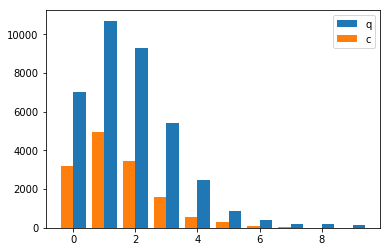

In [836]:
plt.bar(radii,angle_df_q,0.4,align='edge',label="q")
plt.bar(radii,angle_df,-0.4,align='edge',label="c")
plt.legend()

## find snapshot with 6 115-125 angles

In [867]:
#find snapshot with 6 115-125 angles
numframes=0
label = set()

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    tmp_angle = angles[angles<125]
    if(len(tmp_angle[tmp_angle>115])>=6):
        label.add(numframes)
    numframes+=1

In [868]:
mark = list(label)
mark.sort()
for ss in np.split(mark,np.where(np.diff(mark)!=1)[0]+1):
    tmp = snap_c[ss[0]].copy()
    tmp.wrap(tmp.get_scaled_positions()[0])
    tmp.write(str(ss[0])+".xyz")

In [882]:
sn = snap_c[121]
Os = range(1,64)
tmp = sn.get_distances(0,Os,mic=True)
Os = np.where(tmp<3.83)[0]+1
angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
angles = sn.get_angles(angles_input,mic=True)
print(angles_input[(angles<125)&(angles>115),0:3:2])
print(tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1])

[[ 4 15]
 [ 4 24]
 [ 4 31]
 [14 24]
 [15 24]
 [24 58]]
[[3.6787256  3.33892689]
 [3.6787256  3.22377521]
 [3.6787256  3.50601295]
 [3.48544286 3.22377521]
 [3.33892689 3.22377521]
 [3.22377521 3.57722772]]


In [1259]:
nbead=0
nsnap=0
label_q = set()

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        tmp_angle = angles[angles<125]
        if(len(tmp_angle[tmp_angle>115])>=9):
            label_q.add((nbead,nsnap))
        nsnap+=1
    nbead += 1
    nsnap = 0

In [1504]:
mark_q = list(label_q)
mark_q.sort()
for nb,ns in mark_q[0:100:20]:
    tmp = snap[nb][ns].copy()
    tmp.wrap(tmp.get_scaled_positions()[0])
    tmp.write(str(nb)+"-"+str(ns)+".xyz")

In [1509]:
for nb,ns in [mark_q[80]]:
    print(nb,ns)
    sn = snap[nb][ns].copy()
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
    angles = sn.get_angles(angles_input,mic=True)
    print(angles_input[(angles<125)&(angles>115),0:3:2])
    print(tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1])

2 684
[[ 4 27]
 [ 7 44]
 [ 7 61]
 [ 7 63]
 [15 50]
 [15 63]
 [27 61]
 [31 44]
 [31 61]]
[[3.58217458 3.23981277]
 [3.15511117 3.72675928]
 [3.15511117 3.6578012 ]
 [3.15511117 3.23345001]
 [3.16040822 3.50120891]
 [3.16040822 3.23345001]
 [3.23981277 3.6578012 ]
 [3.32945347 3.72675928]
 [3.32945347 3.6578012 ]]


## shift of hydration shell center and CN in snapshot with 4 115-125 angles

In [755]:
#calculate shift of hydration box center in snapshot with 4 115-125 angles
import itertools
rdf,edges = np.histogram([],200,(0,2))
cn,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    tmp_angle = angles[angles<125]
    if(len(tmp_angle[tmp_angle>115])>=4):
        dis = sn.get_distances(0,Os,mic=True,vector=True)
        rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
        cn += np.histogram(len(Os),11,(0,11))[0]
        numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift = rdf/numframes/vol


In [756]:
#calculate shift of hydration box center in snapshot with 4 115-125 angles_q
rdf,edges = np.histogram([],200,(0,2))
cn_q,cn_edges = np.histogram([],11,(0,11))
numframes = 0.


for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        tmp_angle = angles[angles<125]
        if(len(tmp_angle[tmp_angle>115])==4):
            dis = sn.get_distances(0,Os,mic=True,vector=True)
            rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
            cn_q += np.histogram(len(Os),11,(0,11))[0]
            numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift_q = rdf/numframes/vol

In [837]:
#calculate shift of hydration box center in snapshot with >=3 115-125 angles
rdf,edges = np.histogram([],200,(0,2))
cn_angle_3,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    tmp_angle = angles[angles<125]
    if(len(tmp_angle[tmp_angle>115])>=3):
        dis = sn.get_distances(0,Os,mic=True,vector=True)
        rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
        cn_angle_3 += np.histogram(len(Os),11,(0,11))[0]
        numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift = rdf/numframes/vol

#calculate shift of hydration box center in snapshot with >=3 115-125 angles_q
rdf,edges = np.histogram([],200,(0,2))
cn_angle_3_q,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        tmp_angle = angles[angles<125]
        if(len(tmp_angle[tmp_angle>115])>=3):
            dis = sn.get_distances(0,Os,mic=True,vector=True)
            rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
            cn_angle_3_q += np.histogram(len(Os),11,(0,11))[0]
            numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift_q = rdf/numframes/vol

<BarContainer object of 11 artists>

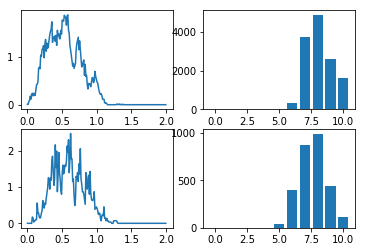

In [838]:
fig,ax = plt.subplots(2,2)
ax[1,0].plot(radii,a_center_shift)
ax[1,1].bar(cn_radii,cn_angle_3)
ax[0,0].plot(radii,a_center_shift_q)
ax[0,1].bar(cn_radii,cn_angle_3_q)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


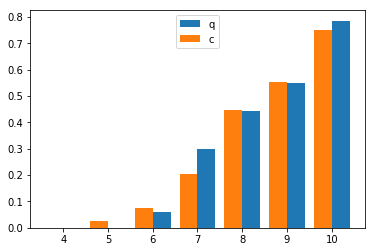

In [842]:
plt.bar(cn_radii,cn_angle_3_q/pure_cn_q,0.4,align='edge',label="q")
plt.bar(cn_radii,cn_angle_3/pure_cn,-0.4,align='edge',label="c")
plt.legend()

In [843]:
#calculate shift of hydration box center in snapshot with >=2 115-125 angles
rdf,edges = np.histogram([],200,(0,2))
cn_angle_2,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
    tmp_angle = angles[angles<125]
    if(len(tmp_angle[tmp_angle>115])>=2):
        dis = sn.get_distances(0,Os,mic=True,vector=True)
        rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
        cn_angle_2 += np.histogram(len(Os),11,(0,11))[0]
        numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift_2 = rdf/numframes/vol

#calculate shift of hydration box center in snapshot with >=2 115-125 angles_q
rdf,edges = np.histogram([],200,(0,2))
cn_angle_2_q,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1),mic=True)
        tmp_angle = angles[angles<125]
        if(len(tmp_angle[tmp_angle>115])>=2):
            dis = sn.get_distances(0,Os,mic=True,vector=True)
            rdf += np.histogram(np.linalg.norm(dis.mean(axis=0)),200,(0,2))[0]
            cn_angle_2_q += np.histogram(len(Os),11,(0,11))[0]
            numframes += 1
    

rdf.astype(np.float64)
radii = 0.5 * (edges[1:] + edges[:-1])
cn_radii = cn_edges[:-1]
vol = edges[1:] - edges[:-1]
a_center_shift_2_q = rdf/numframes/vol

<BarContainer object of 11 artists>

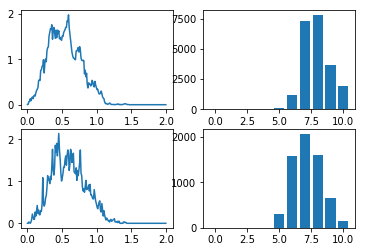

In [844]:
fig,ax = plt.subplots(2,2)
ax[1,0].plot(radii,a_center_shift_2)
ax[1,1].bar(cn_radii,cn_angle_2)
ax[0,0].plot(radii,a_center_shift_2_q)
ax[0,1].bar(cn_radii,cn_angle_2_q)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


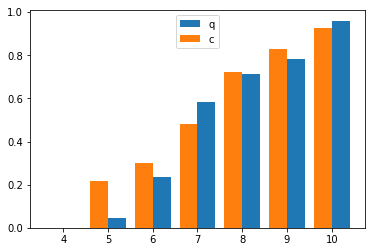

In [900]:
plt.bar(cn_radii,cn_angle_2_q/pure_cn_q,0.4,align='edge',label="q")
plt.bar(cn_radii,cn_angle_2/pure_cn,-0.4,align='edge',label="c")
plt.legend()

## angle relation between OCl

In [845]:
df,edges = np.histogram([],100,(0,4))
pointscount = 0

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
    angles = sn.get_angles(angles_input,mic=True)
    result = tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1]
    df += np.histogram(result,100,(0,4))[0]
    pointscount += result.size

vol = edges[1:] - edges[:-1]
D_angle_OCl_x = 0.5 * (edges[1:] + edges[:-1])
D_angle_OCl= df/pointscount/vol

df,edges = np.histogram([],100,(0,4))
pointscount = 0
for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
        angles = sn.get_angles(angles_input,mic=True)
        result = tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1]
        df += np.histogram(result,100,(0,4))[0]
        pointscount += result.size
        
vol = edges[1:] - edges[:-1]
D_angle_OCl_x = 0.5 * (edges[1:] + edges[:-1])
D_angle_OCl_q = df/pointscount/vol

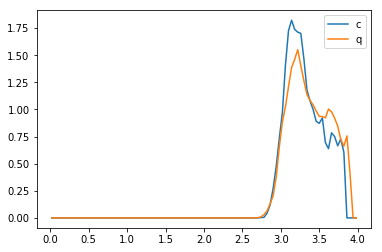

In [846]:
plt.plot(D_angle_OCl_x,D_angle_OCl,label="c")
plt.plot(D_angle_OCl_x,D_angle_OCl_q,label="q")
plt.legend()
#plt.plot(G_ClO_x,G_ClO_c)
#plt.plot(G_ClO_x,G_ClO_q)

## Angle relation between OO distance

In [ ]:
df,edges = np.histogram([],100,(0,4))
pointscount = 0

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
    angles = sn.get_angles(angles_input,mic=True)
    result = tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1]
    df += np.histogram(result,100,(0,4))[0]
    pointscount += result.size

vol = edges[1:] - edges[:-1]
D_angle_OCl_x = 0.5 * (edges[1:] + edges[:-1])
D_angle_OCl= df/pointscount/vol

df,edges = np.histogram([],100,(0,4))
pointscount = 0
for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
        angles = sn.get_angles(angles_input,mic=True)
        result = tmp[angles_input[(angles<125)&(angles>115),0:3:2]-1]
        df += np.histogram(result,100,(0,4))[0]
        pointscount += result.size
        
vol = edges[1:] - edges[:-1]
D_angle_OCl_x = 0.5 * (edges[1:] + edges[:-1])
D_angle_OCl_q = df/pointscount/vol

In [862]:
sn = snap_c[1471]

In [863]:
sn = snap_c[1471]
Os = range(1,64)
tmp = sn.get_distances(0,Os,mic=True)
Os = np.where(tmp<3.8)[0]+1
angles_input = np.insert(np.asarray(list(itertools.combinations(Os,2))),1,0,axis=1)
angles = sn.get_angles(angles_input,mic=True)
angles_input[(angles<125)&(angles>115),0:3:2]-1

array([[42, 55]])

# Coordination Number

In [840]:
#calculate cn
pure_cn,cn_edges = np.histogram([],11,(0,11))
numframes = 0.

for sn in snap_c:
    Os = range(1,64)
    tmp = sn.get_distances(0,Os,mic=True)
    Os = np.where(tmp<3.83)[0]+1
    pure_cn += np.histogram(len(Os),11,(0,11))[0]
    numframes += 1
    
cn_radii = cn_edges[:-1]


#calculate shift of hydration box center in snapshot with >=3 115-125 angles_q
pure_cn_q,cn_edges = np.histogram([],11,(0,11))
numframes_q = 0.

for beads in snap:
    for sn in beads:
        Os = range(1,64)
        tmp = sn.get_distances(0,Os,mic=True)
        Os = np.where(tmp<3.9)[0]+1
        pure_cn_q += np.histogram(len(Os),11,(0,11))[0]
        numframes_q += 1
    
cn_radii = cn_edges[:-1]

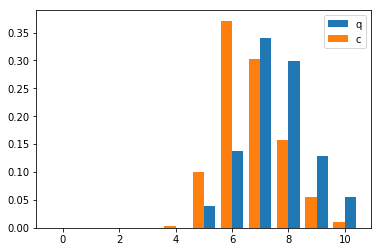

In [841]:
plt.bar(cn_radii,pure_cn_q/numframes_q,0.4,align='edge',label="q")
plt.bar(cn_radii,pure_cn/numframes,-0.4,align='edge',label="c")
plt.legend()

# Wannier Center ana

In [1323]:
wan_c = ase.io.read("/Users/jianhangxu/Library/Mobile Documents/com~apple~CloudDocs/study/work/2WCl/4sum/7wanniers/classical_wanniers.xyz",":")
wan_q = ase.io.read("/Users/jianhangxu/Library/Mobile Documents/com~apple~CloudDocs/study/work/2WCl/4sum/7wanniers/quantum_wanniers.xyz",":")

In [1327]:
#set pbc and cp
for sn in wan_c:
    sn.set_pbc(111)
    sn.set_cell([23.47*Bohr,23.47*Bohr,23.47*Bohr])
for sn in wan_q:
    sn.set_pbc(111)
    sn.set_cell([23.47*Bohr,23.47*Bohr,23.47*Bohr])
    #sn.set_positions(sn.get_positions()*Bohr)
#0-255 X 256 Cl 257-319 O 320-445 H

## G_OW

In [1353]:
D_OW_c = DF(100,(0.25,0.55))
D_OW_q = DF(100,(0.25,0.55))
D_OW_first_c = DF(100,(0.25,0.55))
D_OW_first_q = DF(100,(0.25,0.55))
for sn in wan_c:
    all_dist = sn.get_all_distances(mic=True)
    #all 
    Os_wan_dist = all_dist[257:320,0:256]
    D_OW_c.read(Os_wan_dist[Os_wan_dist<1])
    #in first shell
    Os = np.where(all_dist[256][257:320]<3.83)[0]+257
    Os_wan_dist = all_dist[Os][:,0:256]
    D_OW_first_c.read(Os_wan_dist[Os_wan_dist<1])
for sn in wan_q:
    all_dist = sn.get_all_distances(mic=True)
    Os_wan_dist = all_dist[257:320,0:256]
    D_OW_q.read(Os_wan_dist[Os_wan_dist<1])
    Os = np.where(all_dist[256][257:320]<3.83)[0]+257
    Os_wan_dist = all_dist[Os][:,0:256]
    D_OW_first_q.read(Os_wan_dist[Os_wan_dist<1])

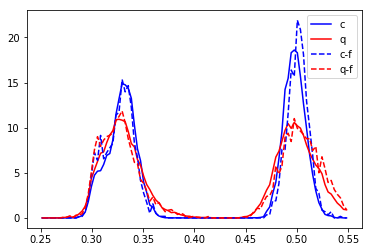

In [1354]:
plt.plot(D_OW_c.get_x(),D_OW_c.get_y(),color="blue",label='c')
plt.plot(D_OW_q.get_x(),D_OW_q.get_y(),color='red',label='q')
plt.plot(D_OW_first_c.get_x(),D_OW_first_c.get_y(),color="blue",linestyle='--',label='c-f')
plt.plot(D_OW_first_q.get_x(),D_OW_first_q.get_y(),color='red',linestyle='--',label='q-f')
plt.legend()

In [1361]:
D_ClW_c = DF(100,(0.25,0.55))
D_ClW_q = DF(100,(0.25,0.55))
D_WCLW_c = DF(100,(0,180))
D_WCLW_q = DF(100,(0,180))

for sn in wan_c:
    Cl_wan_dist = sn.get_distances(256,range(256),mic=True) 
    Cl_wan_index = np.where(Cl_wan_dist<1)[0]
    D_ClW_c.read(Cl_wan_dist[Cl_wan_index])
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Cl_wan_index,2))),1,256,axis=1),mic=True)
    D_WCLW_c.read(angles)
    
for sn in wan_q:
    Cl_wan_dist = sn.get_distances(256,range(256),mic=True) 
    Cl_wan_index = np.where(Cl_wan_dist<1)[0]
    D_ClW_q.read(Cl_wan_dist[Cl_wan_index])
    angles = sn.get_angles(np.insert(np.asarray(list(itertools.combinations(Cl_wan_index,2))),1,256,axis=1),mic=True)
    D_WCLW_q.read(angles)


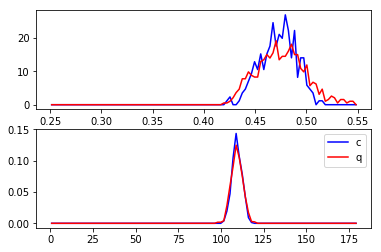

In [1364]:
fig,ax = plt.subplots(2)
ax[0].plot(D_ClW_c.get_x(),D_ClW_c.get_y(),color="blue",label='c')
ax[0].plot(D_ClW_q.get_x(),D_ClW_q.get_y(),color='red',label='q')
ax[1].plot(D_WCLW_c.get_x(),D_WCLW_c.get_y(),color="blue",label='c')
ax[1].plot(D_WCLW_q.get_x(),D_WCLW_q.get_y(),color='red',label='q')
plt.legend()

In [ ]:
"""atomic_number = test.get_atomic_numbers()
nO = np.where(atomic_number==8)[0]
nH = np.where(atomic_number==1)[0]
#len(np.where(test.get_all_distances()[nO][:,np.concatenate((nO,nH),axis=1)]<1.26))
#
#np.ix_(nO,nH)
#np.where(test.get_distances(1,nH,mic=True)<1.26)
#np.where(test.get_all_distances(mic=True)[nO][:,np.concatenate((nO,nH))]<1.26)[1].reshape(63,3)
nH[np.where(test.get_all_distances(mic=True)[nO][:,nH]<1.26)[1]]#[1].reshape(63,3)
"""

In [ ]:
"""def get_water(atoms):
    "return 2d numpy.ndarray of O H H"
    OH_cutoff = 1.26
    atomic_number = atoms.get_atomic_numbers()
    nO = np.where(atomic_number==8)[0]
    nH = np.where(atomic_number==1)[0]
    """
"""
    atomic_distance = atoms.get_all_distances(mic=True)[nO][:,np.concatenate((nO,nH))]
    selected_atoms = np.where(atomic_distance<OH_cutoff)
    if(len(selected_atoms[1]) != len(nO)*3):
        selected_atoms2 = np.zeros([len(nO),3],np.int_)
        for i in range(0,len(nO)):
            if(len(np.where(selected_atoms[0]==i)[0])!=3):
                #print(selected_atoms[1][np.where(selected_atoms[0]==i)])
                selected_atoms2[i] = np.where(atomic_distance<OH_cutoff )
            else:
                selected_atoms2[i] = selected_atoms[1][np.where(selected_atoms[0]==i)]
        return selected_atoms2
    return selected_atoms[1].reshape(len(nO),3)
    """

In [ ]:
"""
class water:
    def __init__(self,atoms=None,OH_cutoff=None):
        if(OH_cutoff==None):
            self.OH_cutoff=1.26
        else:
            self.OH_cutoff=OH_cutoff
        if(atoms==None):
            pass
        else:
            self.get_waters(atoms)
    
    def get_waters(self,atoms):
        atomic_number = atoms.get_atomic_numbers()
        nO = np.where(atomic_number==8)[0]
        nH = np.where(atomic_number==1)[0]
        self.array = nO
        
    """


In [ ]:
"""
def donate_HB(sn,water1,water2):
        detect if water1's H donate to water2
    global HB_OO_cutoff,HB_HOO_cutoff
    if(0.1<sn.get_distance(water1[0],water2[0],mic=True)<HB_OO_cutoff):
        if(sn.get_angle(water1[1],water1[0],water2[0],mic=True)<HB_HOO_cutoff):
            return True
        if(sn.get_angle(water1[2],water1[0],water2[0],mic=True)<HB_HOO_cutoff):
            return True
        return False
    
for sn in snap_c:
    ss_HB_a = np.zeros(63)
    ss_HB_d = np.zeros(63)
    sn.get_distance
    for water1 in waters:
        for water2 in waters:
            if(donate_HB(sn,water1,water2)):
                ss_HB_a[water2[0]-1] += 1
                ss_HB_d[water1[0]-1] += 1
    accept_DF += np.histogram(ss_HB_a,6,(0,6))[0]
    donate_DF += np.histogram(ss_HB_d,6,(0,6))[0]
    numaccept += ss_HB_a.mean()
    numdonate += ss_HB_d.mean()
    numframes += 1
    print(numframes)
"""